## 1. Import libraries


In [1]:
import random, os, glob, json, tqdm, warnings #type:ignore
import tensorflow as tf #type:ignore

from keras import layers, models, optimizers, callbacks #type:ignore
from keras.layers import Input,  concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout    #type:ignore
from keras.models import Model  #type:ignore

import numpy as np  #type:ignore
import pandas as pd #type:ignore

import matplotlib.pyplot as plt #type:ignore
import seaborn as sns   #type:ignore

from PIL import Image, ImageEnhance #type:ignore
import albumentations as A  #type:ignore
import cv2, skimage #type:ignore

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

# Reduce TensorFlow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

2025-07-31 21:34:48.749162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 21:34:49.254298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-07-31 21:34:49.254298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

import torch
print(torch.cuda.get_device_name(0))

2025-07-31 21:34:50.636831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-31 21:34:50.670488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-31 21:34:50.672726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
NVIDIA GeForce RTX 3070 Ti
NVIDIA GeForce RTX 3070 Ti


## 2. Download and Extract Carvana Dataset

1. **Download the Dataset**:
   - Use Kaggle API to download the Carvana Image Masking Challenge dataset
   - Command: `kaggle competitions download -c carvana-image-masking-challenge`

2. **Extract the Files**:
   - Create organized directory structure for the project
   - Extract train.zip to train/ folder
   - Extract train_masks.zip to train_masks/ folder
   - Extract test.zip to test/ folder
   - Keep the original zip files for backup

5. **Verify Dataset Structure**:
   - Check that all folders contain expected files
   - Count total number of training images and masks

In [3]:
# # ---------------------------------------------------------------------------- #
# #                                DOWNLOAD FILES                                #
# # ---------------------------------------------------------------------------- #

# # !kaggle competitions download -c carvana-image-masking-challenge -f train.zip -p ./carvana-dataset
# # !kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip -p ./carvana-dataset
# # !kaggle competitions download -c carvana-image-masking-challenge -f test.zip -p ./carvana-dataset

# # ---------------------------------------------------------------------------- #
# #                               EXTRACT THE FILES                              #
# # ---------------------------------------------------------------------------- #

# import zipfile

# # Create directories if they don't exist
# os.makedirs('./carvana-dataset/train/', exist_ok=True)
# os.makedirs('./carvana-dataset/train_masks/', exist_ok=True)
# os.makedirs('./carvana-dataset/test/', exist_ok=True)

# # Extract train images
# with zipfile.ZipFile('./carvana-dataset/train.zip', 'r') as zip_ref:
#     zip_ref.extractall('./carvana-dataset/')

# # Extract train masks
# with zipfile.ZipFile('./carvana-dataset/train_masks.zip', 'r') as zip_ref:
#     zip_ref.extractall('./carvana-dataset/')

# # Extract test images
# with zipfile.ZipFile('./carvana-dataset/test.zip', 'r') as zip_ref:
#     zip_ref.extractall('./carvana-dataset/')

# # Verify dataset structure
# print("Train images:", len(os.listdir('./carvana-dataset/train/')))
# print("Train masks:", len(os.listdir('./carvana-dataset/train_masks/')))
# print("Test images:", len(os.listdir('./carvana-dataset/test/')))
# print("Dataset download and extraction completed!")

# # Print file counts
# print("File count in './carvana-dataset/train/':", len(os.listdir('./carvana-dataset/train/')))
# print("File count in './carvana-dataset/train_masks/':", len(os.listdir('./carvana-dataset/train_masks/')))
# print("File count in './carvana-dataset/test/':", len(os.listdir('./carvana-dataset/test/')))

## 3. Data Exploration and Visualization

1. **Dataset Overview**:
   - Count total number of training images and masks
   - Check if every training image has a corresponding mask

In [4]:
# ---------------------------------------------------------------------------- #
#                                  DIRECTORIES                                 #
# ---------------------------------------------------------------------------- #

TRAIN_IMAGES_DIR = "carvana-dataset/train"
TRAIN_MASKS_DIR = "carvana-dataset/train_masks"
TEST_IMAGES_DIR = "carvana-dataset/test"

# ---------------------------------------------------------------------------- #
#                       LISTS TO STORE IMAGE DIRECTORIES                       #
# ---------------------------------------------------------------------------- #

train_set = []
train_mask_set = []
test_set = []

# ---------------------------------------------------------------------------- #
#                        PRINT COUNT OF IMAGES AND MASKS                       #
# ---------------------------------------------------------------------------- #

print("Train images: ", len(glob.glob(os.path.join(TRAIN_IMAGES_DIR, "*.*"))))
print("Train masks: ", len(glob.glob(os.path.join(TRAIN_MASKS_DIR, "*.*"))))
print("Test images: ", len(glob.glob(os.path.join(TEST_IMAGES_DIR, "*.*"))))

# ---------------------------------------------------------------------------- #
#            APPENDING LISTS WITH IMAGE PATHS IN ALPHABETICAL ORDER            #
# ---------------------------------------------------------------------------- #

# TRAINING IMAGES
if os.path.exists(TRAIN_IMAGES_DIR):
    for image_filename in sorted(os.listdir(TRAIN_IMAGES_DIR)):
        # Create full path to the image
        image_path = os.path.join(TRAIN_IMAGES_DIR, image_filename)
        train_set.append(image_path)
else:
    print(f"Directory {TRAIN_IMAGES_DIR} not found. Please check if the dataset is extracted correctly.")

# TRAINING MASKS
if os.path.exists(TRAIN_MASKS_DIR):
    for image_filename in sorted(os.listdir(TRAIN_MASKS_DIR)):
        # Create full path to the image
        image_path = os.path.join(TRAIN_MASKS_DIR, image_filename)
        train_mask_set.append(image_path)
else:
    print(f"Directory {TRAIN_MASKS_DIR} not found. Please check if the dataset is extracted correctly.")

# TEST IMAGES
if os.path.exists(TEST_IMAGES_DIR):
    for image_filename in sorted(os.listdir(TEST_IMAGES_DIR)):
        # Create full path to the image
        image_path = os.path.join(TEST_IMAGES_DIR, image_filename)
        test_set.append(image_path)
else:
    print(f"Directory {TEST_IMAGES_DIR} not found. Please check if the dataset is extracted correctly.")

# ---------------------------------------------------------------------------- #
#                           VERIFY CORRESPONDING MASK                          #
# ---------------------------------------------------------------------------- #

missing_masks = []
for image_path in train_set:
    # Derive mask filename from image filename
    image_filename = os.path.basename(image_path)
    mask_filename = image_filename.replace('.jpg', '_mask.gif')
    mask_path = os.path.join(TRAIN_MASKS_DIR, mask_filename)
    if not os.path.exists(mask_path):
        missing_masks.append(image_filename)

if missing_masks:
    print(f"Missing masks for {len(missing_masks)} images:")
    print(missing_masks[:10])  # Show first 10 missing
else:
    print("All training images have corresponding masks.")

# ---------------------------------------------------------------------------- #
#                                 PRINT SAMPLES                                #
# ---------------------------------------------------------------------------- #

print(train_set[:4])
print(train_mask_set[:4])
print(test_set[:4])

Train images:  5088
Train masks:  5088
Test images:  100064
All training images have corresponding masks.
['carvana-dataset/train/00087a6bd4dc_01.jpg', 'carvana-dataset/train/00087a6bd4dc_02.jpg', 'carvana-dataset/train/00087a6bd4dc_03.jpg', 'carvana-dataset/train/00087a6bd4dc_04.jpg']
['carvana-dataset/train_masks/00087a6bd4dc_01_mask.gif', 'carvana-dataset/train_masks/00087a6bd4dc_02_mask.gif', 'carvana-dataset/train_masks/00087a6bd4dc_03_mask.gif', 'carvana-dataset/train_masks/00087a6bd4dc_04_mask.gif']
['carvana-dataset/test/0004d4463b50_01.jpg', 'carvana-dataset/test/0004d4463b50_02.jpg', 'carvana-dataset/test/0004d4463b50_03.jpg', 'carvana-dataset/test/0004d4463b50_04.jpg']
All training images have corresponding masks.
['carvana-dataset/train/00087a6bd4dc_01.jpg', 'carvana-dataset/train/00087a6bd4dc_02.jpg', 'carvana-dataset/train/00087a6bd4dc_03.jpg', 'carvana-dataset/train/00087a6bd4dc_04.jpg']
['carvana-dataset/train_masks/00087a6bd4dc_01_mask.gif', 'carvana-dataset/train_mask

2. **Image Properties Analysis**:
   - Load several sample images and examine their properties:
     - Image dimensions (height, width, channels)
     - Color space (RGB, BGR)

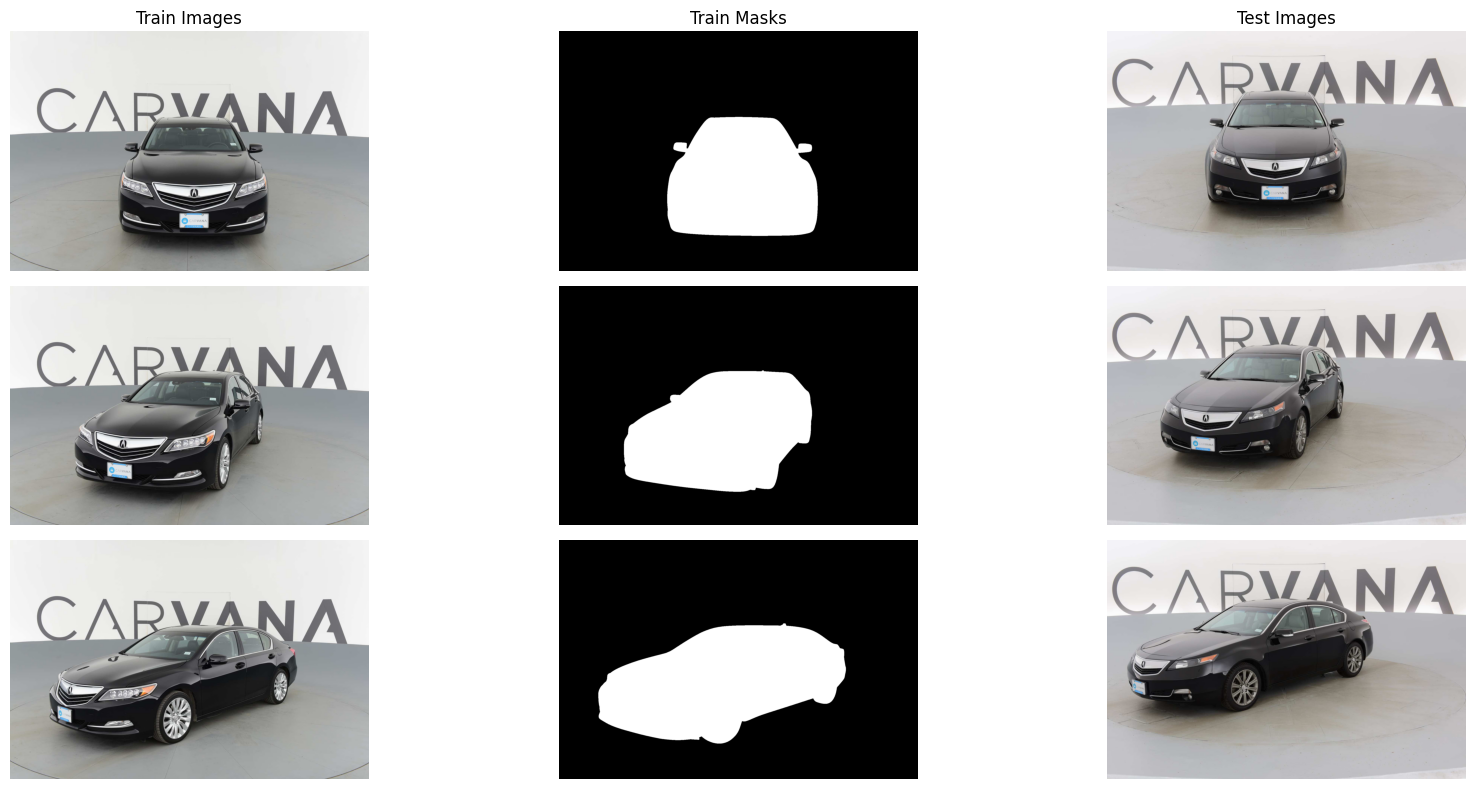

Train Image 1:
  - Size: (1918, 1280) (width x height)
  - Mode: RGB
  - Num Channels: 3

Train Image 2:
  - Size: (1918, 1280) (width x height)
  - Mode: RGB
  - Num Channels: 3

Train Image 3:
  - Size: (1918, 1280) (width x height)
  - Mode: RGB
  - Num Channels: 3



In [5]:
# ---------------------------------------------------------------------------- #
#                                LOADING IMAGES                                #
# ---------------------------------------------------------------------------- #

# Prepare images and labels for each kind
images_to_display = {
    'Train Images': train_set[:3],
    'Train Masks': train_mask_set[:3],
    'Test Images': test_set[:3]
}

# Load images for each kind
images = {kind: [Image.open(path) for path in paths] for kind, paths in images_to_display.items()}

# Plot: each column is a kind, each row is a sample
fig, axes = plt.subplots(3, 3, figsize=(18, 8))
kinds = list(images_to_display.keys())

for col, kind in enumerate(kinds):
    for row, img in enumerate(images[kind]):
        axes[row, col].imshow(img)
        axes[row, col].set_title(kind if row == 0 else "")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------- #
#                               IMAGE PROPERTIES                               #
# ---------------------------------------------------------------------------- #
for idx, img in enumerate(images['Train Images']):
    print(f"Train Image {idx+1}:")
    print(f"  - Size: {img.size} (width x height)")
    print(f"  - Mode: {img.mode}")
    print(f"  - Num Channels: {len(img.getbands())}")
    print("")

3. **Mask Properties Analysis**:
   - Load corresponding mask images and analyze:
     - Mask dimensions (should match original images)
     - Pixel value distribution (0 for background, 255 for car)
     - Data type and format
     - Verify binary nature of masks

In [6]:
# ---------------------------------------------------------------------------- #
#                           MASK PROPERTIES ANALYSIS                           #
# ---------------------------------------------------------------------------- #

df_images_masks = pd.DataFrame({
    "image": train_set,
    "mask": train_mask_set
})
df_images_masks.head()

sample_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in df_images_masks["mask"].head(3)]
for i, mask in enumerate(sample_masks):
    print(f"Mask {i+1}:")
    if mask is not None:
        print("Shape:", mask.shape)
        print("Data type:", mask.dtype)
        print("Unique pixel values:", np.unique(mask))
        print("Value counts:", dict(zip(*np.unique(mask, return_counts=True))))
    else:
        print("Mask could not be loaded. Check the file path or format.")
    print("")

Mask 1:
Mask could not be loaded. Check the file path or format.

Mask 2:
Mask could not be loaded. Check the file path or format.

Mask 3:
Mask could not be loaded. Check the file path or format.



4. **Visual Exploration**:
   - Display a grid of sample images with their corresponding masks
   - Show original image, mask, and masked image side by side
   - Create visualizations showing:
     - Different car types and colors
     - Various camera angles (16 per car)
     - Mask complexity variations

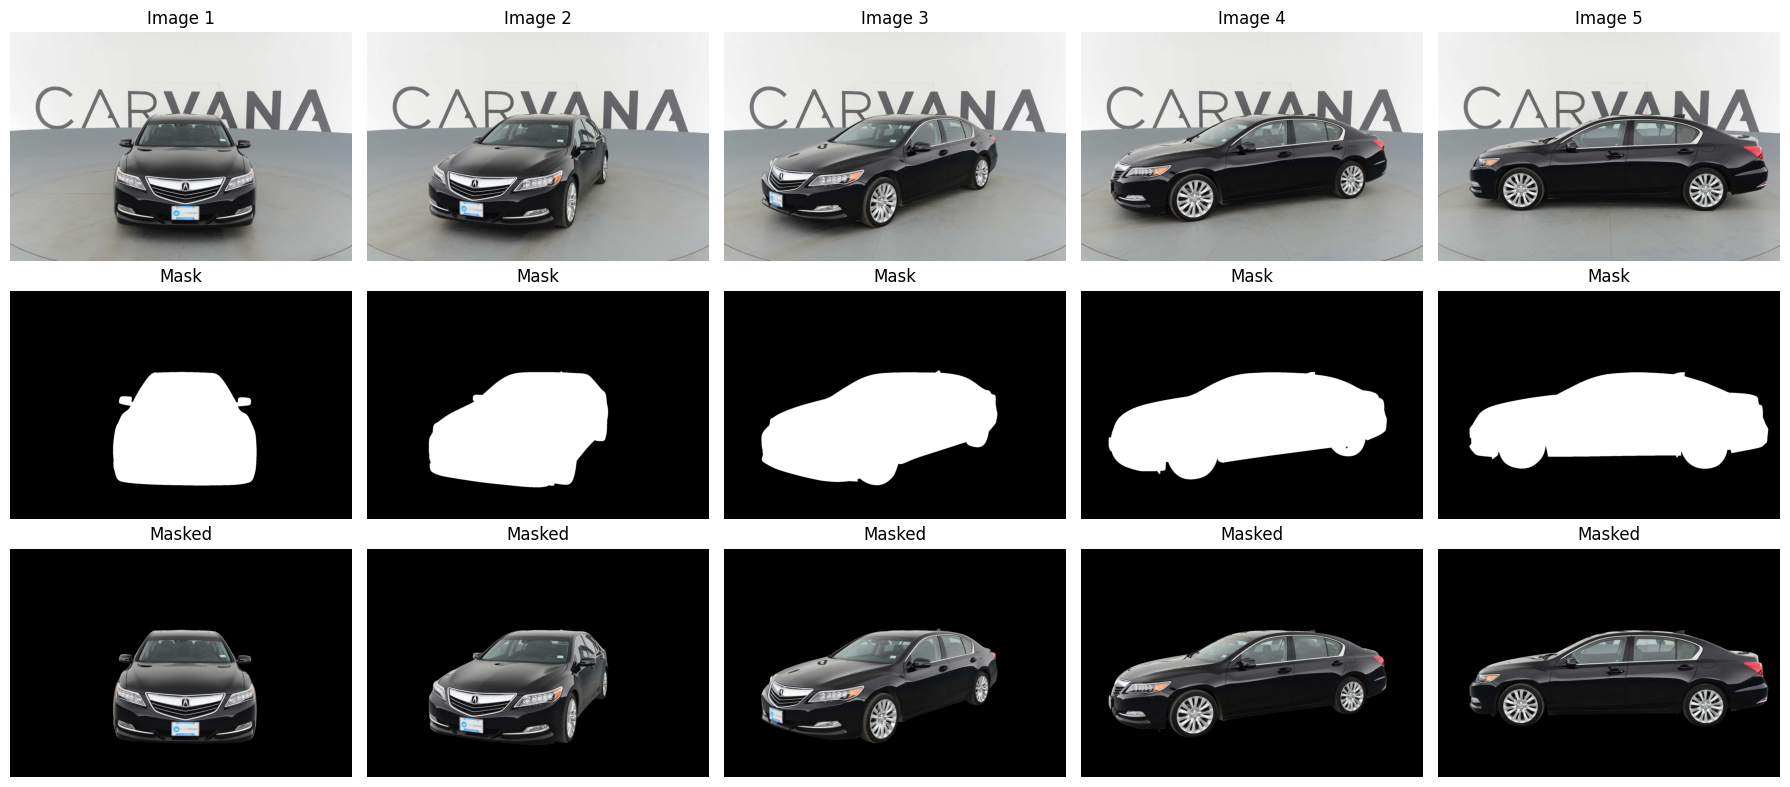

In [7]:
# ---------------------------------------------------------------------------- #
#                 DISPLAY SAMPLES: ORIGINAL, MASK, MASKED IMAGE                #
# ---------------------------------------------------------------------------- #

fig, axes = plt.subplots(3, 5, figsize=(18, 8))

for idx in range(5):
    img_path = df_images_masks.iloc[idx]['image']
    mask_path = df_images_masks.iloc[idx]['mask']

    image = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    mask_np = np.array(mask)
    binary_mask_np = np.where(mask_np > 127, 255, 0).astype(np.uint8)
    binary_mask = Image.fromarray(binary_mask_np)

    background = Image.new('RGB', image.size, (0, 0, 0))
    masked_image = Image.composite(image, background, binary_mask)

    # Original image
    axes[0, idx].imshow(image)
    axes[0, idx].set_title(f"Image {idx+1}")
    axes[0, idx].axis('off')

    # Mask
    axes[1, idx].imshow(mask, cmap='gray')
    axes[1, idx].set_title("Mask")
    axes[1, idx].axis('off')

    # Masked image
    axes[2, idx].imshow(masked_image)
    axes[2, idx].set_title("Masked")
    axes[2, idx].axis('off')

plt.tight_layout()
plt.show()

5. **Statistical Analysis**:
   - Calculate mask coverage statistics:
     - Average percentage of car pixels per image
     - Distribution of car sizes in images
     - Aspect ratio analysis
   - Create histograms showing:
     - Image brightness distributions
     - Mask area distributions
     - Color channel statistics

In [8]:
# ---------------------------------------------------------------------------- #
#                        PRINT CAR PIXEL RATIO IN IMAGES                       #
# ---------------------------------------------------------------------------- #

for idx in range(5):
    img_path = df_images_masks.iloc[idx]['image']
    mask_path = df_images_masks.iloc[idx]['mask']

    mask_array = np.array(Image.open(mask_path)) / 255

    unique_values, counts = np.unique(mask_array, return_counts = True)
    total_pixels = mask_array.size
    car_pixel_ratio = counts[1] / total_pixels

    print(f"Image {idx} foreground ratio: {car_pixel_ratio*100:.1f}%")

Image 0 foreground ratio: 17.7%
Image 1 foreground ratio: 20.2%
Image 2 foreground ratio: 23.5%
Image 3 foreground ratio: 25.4%
Image 4 foreground ratio: 26.3%


6. **Data Quality Checks**:
   - Identify any corrupted or missing files
   - Check for any images without corresponding masks
   - Verify mask quality (clean edges, no artifacts)
   - Look for potential data anomalies

In [9]:
# # ---------------------------------------------------------------------------- #
# #                          CHECK FOR MISSING FILES                             #
# # ---------------------------------------------------------------------------- #

# missing_masks = []
# for image_path in train_set:
# 	# Derive mask path from image path
# 	mask_path = image_path.replace(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR).replace(".jpg", "_mask.gif")
# 	if not os.path.exists(mask_path):
# 		missing_masks.append(image_path)

# if missing_masks:
# 	print(f"Missing masks for {len(missing_masks)} images:")
# 	print(missing_masks[:5])  # Display first 5 missing masks
# else:
# 	print("All training images have corresponding masks.")

# # ---------------------------------------------------------------------------- #
# #                          VERIFY MASK QUALITY                                 #
# # ---------------------------------------------------------------------------- #

# corrupted_masks = []
# for mask_path in train_mask_set:
# 	try:
# 		mask = Image.open(mask_path)
# 		mask.verify()  # Verify if the file is not corrupted
# 	except Exception as e:
# 		corrupted_masks.append(mask_path)

# if corrupted_masks:
# 	print(f"Corrupted masks detected: {len(corrupted_masks)}")
# 	print(corrupted_masks[:5])  # Display first 5 corrupted masks
# else:
# 	print("No corrupted masks detected.")

# # ---------------------------------------------------------------------------- #
# #                          CHECK MASK ANOMALIES                                #
# # ---------------------------------------------------------------------------- #

# anomalous_masks = []
# for mask_path in train_mask_set:
# 	mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# 	if mask is not None:
# 		unique_values = np.unique(mask)
# 		if len(unique_values) > 2 or not np.array_equal(unique_values, [0, 255]):
# 			anomalous_masks.append(mask_path)
# 	else:
# 		print(f"Mask could not be loaded: {mask_path}")

# if anomalous_masks:
# 	print(f"Anomalous masks detected: {len(anomalous_masks)}")
# 	print(anomalous_masks[:5])  # Display first 5 anomalous masks
# else:
# 	print("No anomalies detected in masks.")

## 4. Data Preprocessing and Augmentation

1. **Image Resizing Strategy**:
   - Determine target image size for training (e.g., 256x256, 512x512)
   - Consider memory constraints vs. model performance trade-offs
   - Implement resizing function that maintains aspect ratio
   - Handle both images and masks consistently
   - Choose appropriate interpolation methods (bilinear for images, nearest for masks)

In [10]:
# ---------------------------------------------------------------------------- #
#                           IMAGE RESIZING FUNCTION                            #
# ---------------------------------------------------------------------------- #

def resize_images(image_paths, target_size, batch_size=500, save_dir="carvana-dataset/resized_images_512x512"):
    """
    Resize images to the specified target size in batches, then save to disk.

    Parameters:
        image_paths (list): List of file paths to the images to be resized.
        target_size (tuple): Target size as (width, height).
        batch_size (int): Number of images to process in each batch. Default is 500.
        save_dir (str): Directory to save resized images.

    Returns:
        str: Path to directory containing resized images.
    """
    # Check if directory already exists
    if os.path.exists(save_dir) and len(os.listdir(save_dir)) > 0:
        print(f"Directory '{save_dir}' already exists with files. Skipping resizing.")
        return save_dir
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        print(f"Processing image batch {i//batch_size + 1}/{(len(image_paths) + batch_size - 1)//batch_size}")
        
        for image_path in batch:
            try:
                with Image.open(image_path) as img:
                    resized_img = img.resize(target_size, Image.LANCZOS)    #type: ignore
                    # Save resized image
                    output_path = os.path.join(save_dir, os.path.basename(image_path))
                    resized_img.save(output_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    print(f"Resized images saved to: {save_dir}")
    return save_dir

# ---------------------------------------------------------------------------- #
#                            MASK RESIZING FUNCTION                            #
# ---------------------------------------------------------------------------- #

def resize_masks(mask_paths, target_size, batch_size=500, save_dir="carvana-dataset/resized_masks_512x512"):
    """
    Resize masks to the specified target size in batches, then save to disk.

    Parameters:
        mask_paths (list): List of file paths to the masks to be resized.
        target_size (tuple): Target size as (width, height).
        batch_size (int): Number of masks to process in each batch. Default is 500.
        save_dir (str): Directory to save resized masks.

    Returns:
        str: Path to directory containing resized masks.
    """
    # Check if directory already exists
    if os.path.exists(save_dir) and len(os.listdir(save_dir)) > 0:
        print(f"Directory '{save_dir}' already exists with files. Skipping resizing.")
        return save_dir
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(mask_paths), batch_size):
        batch = mask_paths[i:i + batch_size]
        print(f"Processing mask batch {i//batch_size + 1}/{(len(mask_paths) + batch_size - 1)//batch_size}")
        
        for mask_path in batch:
            try:
                with Image.open(mask_path) as mask:
                    resized_mask = mask.resize(target_size, Image.NEAREST)  #type: ignore
                    # Save resized mask
                    output_path = os.path.join(save_dir, os.path.basename(mask_path))
                    resized_mask.save(output_path)
            except Exception as e:
                print(f"Error processing {mask_path}: {e}")
    
    print(f"Resized masks saved to: {save_dir}")
    return save_dir

In [11]:
# ---------------------------------------------------------------------------- #
#                        RESIZE THEN SAVE IMAGES & MASKS                       #
# ---------------------------------------------------------------------------- #

# Define target size
TARGET_SIZE = (512, 512)

# Process and save resized images (will skip if already exists)
resized_images_dir = resize_images(train_set, TARGET_SIZE, batch_size=200)
print(f"Images processed and saved to: {resized_images_dir}")

# Process and save resized masks (will skip if already exists)
resized_masks_dir = resize_masks(train_mask_set, TARGET_SIZE, batch_size=200)
print(f"Masks processed and saved to: {resized_masks_dir}")

Directory 'carvana-dataset/resized_images_512x512' already exists with files. Skipping resizing.
Images processed and saved to: carvana-dataset/resized_images_512x512
Directory 'carvana-dataset/resized_masks_512x512' already exists with files. Skipping resizing.
Masks processed and saved to: carvana-dataset/resized_masks_512x512


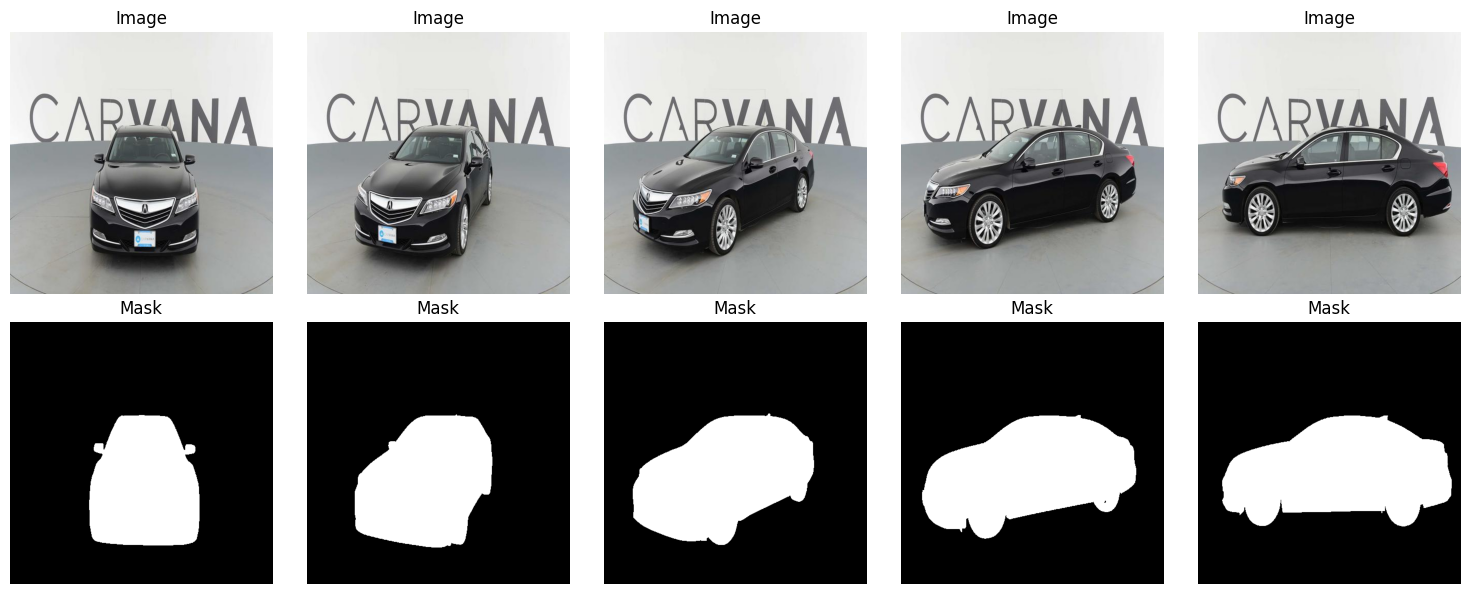

In [12]:
# ---------------------------------------------------------------------------- #
#                 DISPLAY THE FIRST 5 RESIZED IMAGES AND MASKS                 #
# ---------------------------------------------------------------------------- #

resized_images = [Image.open(os.path.join(resized_images_dir, os.path.basename(image_path))) for image_path in train_set[:5]]
resized_masks = [Image.open(os.path.join(resized_masks_dir, os.path.basename(mask_path))) for mask_path in train_mask_set[:5]]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Display images
for ax, img in zip(axes[0], resized_images):
    ax.imshow(img)
    ax.set_title("Image")
    ax.axis('off')

# Display masks
for ax, mask in zip(axes[1], resized_masks):
    ax.imshow(mask, cmap='gray')
    ax.set_title("Mask")
    ax.axis('off')

plt.tight_layout()
plt.show()

2. **Normalization Techniques**:
   - Normalize pixel values to [0, 1] range by dividing by 255
   - Consider alternative normalization strategies:
     - Standard normalization (mean=0, std=1)
     - Per-channel normalization using ImageNet statistics
   - Ensure masks remain binary (0 and 1) after preprocessing

In [13]:
# ---------------------------------------------------------------------------- #
#                        NORMALIZATION FUNCTIONS                               #
# ---------------------------------------------------------------------------- #

def normalize_images(image_paths, target_size=(512, 512), batch_size=500, save_dir="carvana-dataset/normalized_images_512x512"):
    """
    Load, resize, and normalize images to [0, 1] range in batches, then save to disk.

    Parameters:
        image_paths (list): List of file paths to the images to be normalized.
        target_size (tuple): Target size as (width, height).
        batch_size (int): Number of images to process in each batch. Default is 500.
        save_dir (str): Directory to save normalized images.

    Returns:
        str: Path to directory containing normalized images.
    """
    # Check if directory already exists
    if os.path.exists(save_dir) and len(os.listdir(save_dir)) > 0:
        print(f"Directory '{save_dir}' already exists with files. Skipping normalization.")
        return save_dir
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        print(f"Processing image batch {i//batch_size + 1}/{(len(image_paths) + batch_size - 1)//batch_size}")
        
        for image_path in batch:
            try:
                with Image.open(image_path) as img:
                    # Resize and convert to RGB
                    resized_img = img.resize(target_size, Image.LANCZOS).convert('RGB') #type: ignore
                    # Convert to numpy array and normalize
                    img_array = np.array(resized_img).astype(np.float32) / 255.0
                    
                    # Save normalized image as numpy array
                    output_filename = os.path.splitext(os.path.basename(image_path))[0] + '.npy'
                    output_path = os.path.join(save_dir, output_filename)
                    np.save(output_path, img_array)
                    
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    print(f"Normalized images saved to: {save_dir}")
    return save_dir

def normalize_masks(mask_paths, target_size=(512, 512), batch_size=500, save_dir="carvana-dataset/normalized_masks_512x512"):
    """
    Load, resize, and normalize masks to binary [0, 1] values in batches, then save to disk.

    Parameters:
        mask_paths (list): List of file paths to the masks to be normalized.
        target_size (tuple): Target size as (width, height).
        batch_size (int): Number of masks to process in each batch. Default is 500.
        save_dir (str): Directory to save normalized masks.

    Returns:
        str: Path to directory containing normalized masks.
    """
    # Check if directory already exists
    if os.path.exists(save_dir) and len(os.listdir(save_dir)) > 0:
        print(f"Directory '{save_dir}' already exists with files. Skipping normalization.")
        return save_dir
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(mask_paths), batch_size):
        batch = mask_paths[i:i + batch_size]
        print(f"Processing mask batch {i//batch_size + 1}/{(len(mask_paths) + batch_size - 1)//batch_size}")
        
        for mask_path in batch:
            try:
                with Image.open(mask_path) as mask:
                    # Resize and convert to grayscale
                    resized_mask = mask.resize(target_size, Image.NEAREST).convert('L') #type: ignore
                    # Convert to numpy array and make binary
                    mask_array = np.array(resized_mask)
                    binary_mask = (mask_array > 127).astype(np.float32)
                    
                    # Save normalized mask as numpy array
                    output_filename = os.path.splitext(os.path.basename(mask_path))[0] + '.npy'
                    output_path = os.path.join(save_dir, output_filename)
                    np.save(output_path, binary_mask)
                    
            except Exception as e:
                print(f"Error processing {mask_path}: {e}")
    
    print(f"Normalized masks saved to: {save_dir}")
    return save_dir

In [14]:
# ---------------------------------------------------------------------------- #
#                     NORMALIZE AND SAVE IMAGES & MASKS                        #
# ---------------------------------------------------------------------------- #

# Define target size
TARGET_SIZE = (512, 512)

# Process and save normalized images (will skip if already exists)
images_dir = normalize_images(train_set, TARGET_SIZE, batch_size=200)
print(f"Images processed and saved to: {images_dir}")

# Process and save normalized masks (will skip if already exists)
masks_dir = normalize_masks(train_mask_set, TARGET_SIZE, batch_size=200)
print(f"Masks processed and saved to: {masks_dir}")

Directory 'carvana-dataset/normalized_images_512x512' already exists with files. Skipping normalization.
Images processed and saved to: carvana-dataset/normalized_images_512x512
Directory 'carvana-dataset/normalized_masks_512x512' already exists with files. Skipping normalization.
Masks processed and saved to: carvana-dataset/normalized_masks_512x512


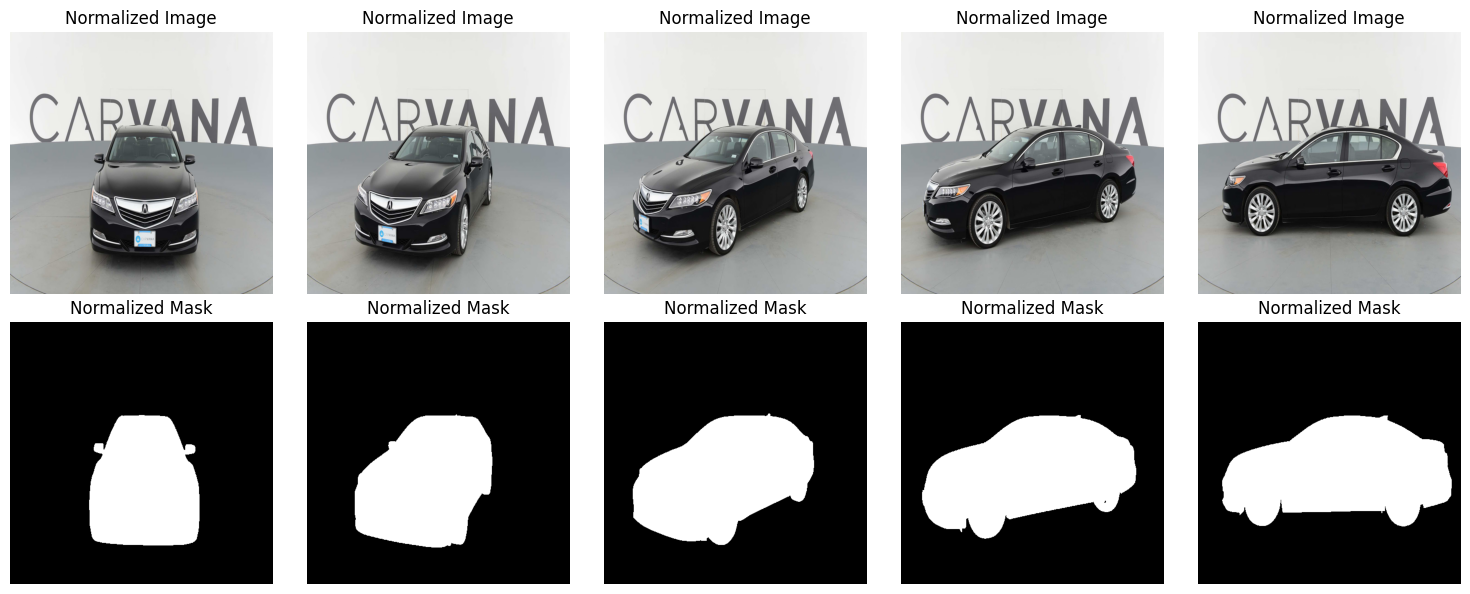

In [15]:
# ---------------------------------------------------------------------------- #
#                DISPLAY THE FIRST 5 NORMALIZED IMAGES AND MASKS               #
# ---------------------------------------------------------------------------- #

normalized_images = [np.load(os.path.join(images_dir, os.path.splitext(os.path.basename(image_path))[0] + '.npy')) for image_path in train_set[:5]]
normalized_masks = [np.load(os.path.join(masks_dir, os.path.splitext(os.path.basename(mask_path))[0] + '.npy')) for mask_path in train_mask_set[:5]]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Display normalized images
for ax, img in zip(axes[0], normalized_images):
    ax.imshow(img)
    ax.set_title("Normalized Image")
    ax.axis('off')

# Display normalized masks
for ax, mask in zip(axes[1], normalized_masks):
    ax.imshow(mask, cmap='gray')
    ax.set_title("Normalized Mask")
    ax.axis('off')

plt.tight_layout()
plt.show()

3. **Data Loading Pipeline**:
   - Create efficient data generator/loader functions
   - Implement batch loading for memory efficiency
   - Set up train/validation split (e.g., 80/20 or 90/10)
   - Ensure reproducible splits using fixed random seeds
   - Handle file path management and error checking

In [16]:
# ---------------------------------------------------------------------------- #
#                              RESIZED DATA LOADER                             #
# ---------------------------------------------------------------------------- #

def load_resized_data(images_dir="carvana-dataset/resized_images_512x512", masks_dir="carvana-dataset/resized_masks_512x512", limit=50):
    """
    Load resized images and masks from disk.

    Parameters:
        images_dir (str): Directory containing resized image files (default: 'carvana-dataset/resized_images_512x512')
        masks_dir (str): Directory containing resized mask files (default: 'carvana-dataset/resized_masks_512x512')
        limit (int, optional): Maximum number of images and masks to load. Default is 50.

    Returns:
        tuple: (resized_images, resized_masks) as lists of PIL Images
    """
    print("Loading resized images...")
    image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
    if limit:
        image_files = image_files[:limit]
    resized_images = []
    for img_file in image_files:
        img = Image.open(os.path.join(images_dir, img_file))
        resized_images.append(img)

    print("Loading resized masks...")
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
    if limit:
        mask_files = mask_files[:limit]
    resized_masks = []
    for mask_file in mask_files:
        mask = Image.open(os.path.join(masks_dir, mask_file))
        resized_masks.append(mask)

    return resized_images, resized_masks


# ---------------------------------------------------------------------------- #
#                            NORMALIZED DATA LOADER                            #
# ---------------------------------------------------------------------------- #
def load_normalized_data(images_dir="carvana-dataset/normalized_images_512x512", masks_dir="carvana-dataset/normalized_masks_512x512", limit=50):
    """
    Load normalized images and masks from disk.

    Parameters:
        images_dir (str): Directory containing normalized image .npy files (default: 'carvana-dataset/normalized_images_512x512')
        masks_dir (str): Directory containing normalized mask .npy files (default: 'carvana-dataset/normalized_masks_512x512')
        limit (int, optional): Maximum number of images and masks to load. Default is 50.

    Returns:
        tuple: (normalized_images, normalized_masks) as lists of numpy arrays
    """
    print("Loading normalized images...")
    image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith('.npy')])
    if limit:
        image_files = image_files[:limit]
    normalized_images = []
    for img_file in image_files:
        img = np.load(os.path.join(images_dir, img_file))
        normalized_images.append(img)

    print("Loading normalized masks...")
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.lower().endswith('.npy')])
    if limit:
        mask_files = mask_files[:limit]
    normalized_masks = []
    for mask_file in mask_files:
        mask = np.load(os.path.join(masks_dir, mask_file))
        normalized_masks.append(mask)

    return normalized_images, normalized_masks


In [17]:
# ---------------------------------------------------------------------------- #
#                                 TEST LOADERS                                 #
# ---------------------------------------------------------------------------- #

resized_images, resized_masks = load_resized_data(resized_images_dir, resized_masks_dir)
normalized_images, normalized_masks = load_normalized_data(images_dir, masks_dir)

print(f"Loaded {len(resized_images)} images and {len(resized_masks)} masks.")
print(f"Loaded {len(normalized_images)} images and {len(normalized_masks)} masks.")

# Delete loaded images and masks to free memory
del normalized_images, resized_images

Loading resized images...
Loading resized masks...
Loading normalized images...
Loading normalized masks...
Loaded 50 images and 50 masks.
Loaded 50 images and 50 masks.


In [18]:
# ---------------------------------------------------------------------------- #
#                             COUNT OF RESIZED DATA                            #
# ---------------------------------------------------------------------------- #

resized_images_count = len(os.listdir(resized_images_dir))
resized_masks_count = len(os.listdir(resized_masks_dir))
print(f"Resized images count: {resized_images_count}")
print(f"Resized masks count: {resized_masks_count}")

# ---------------------------------------------------------------------------- #
#                           COUNT OF NORMALIZED DATA                           #
# ---------------------------------------------------------------------------- #

normalized_images_count = len(os.listdir(images_dir))
normalized_masks_count = len(os.listdir(masks_dir))
print(f"Normalized images count: {normalized_images_count}")
print(f"Normalized masks count: {normalized_masks_count}")

# ---------------------------------------------------------------------------- #
#              COMPARE COUNTS WITH ORIGINAL TRAIN IMAGES AND MASKS             #
# ---------------------------------------------------------------------------- #

if resized_images_count == len(train_set) and resized_masks_count == len(train_mask_set) and \
    normalized_images_count == len(train_set) and normalized_masks_count == len(train_mask_set):
     print("Verification successful: Resized and normalized counts match the original train images and masks count.")
else:
     print("Verification failed: Counts do not match.")

Resized images count: 5088
Resized masks count: 5088
Normalized images count: 5088
Normalized masks count: 5088
Verification successful: Resized and normalized counts match the original train images and masks count.


4. **Data Augmentation Strategies**:
   - **Geometric Transformations**:
     - Horizontal and vertical flipping
     - Random rotation (small angles, e.g., ±30 degrees)
     - Random cropping and scaling
     - Elastic deformation for more robust training (Useful in medical domain)
   
   - **Photometric Augmentations**:
     - Brightness adjustment (±20%)
     - Contrast modification
     - Color jittering (hue, saturation adjustments)
     - Gaussian noise addition
   
   - **Advanced Augmentations**:
     - Random shadow and highlight simulation
     - Perspective transformation
     - Motion blur effects
     - Weather condition simulation

   - **Chosen Augmentation Settings**

     - **Geometric Transformations**
         - Horizontal and Vertical Flipping <br>
         - ```30``` Degrees Rotation <br>
         - Zoom ```0.8 - 1.2``` <br>

     - **Photometric Augmentations**
         - Brightness ```0.7 - 1.3``` <br>
         - Contrast ```0.7 - 1.3``` <br>
         - Gaussian Noise (Mean 0) ```0.01 - 0.05``` <br>
         - Gamma Range ```0.8 - 1.2``` <br>

     - **Advanced Augmentations**
         - Gaussian Blur ```0.1 - 0.7``` <br>
         - Sharpening Alpha ```0.1 - 0.3``` <br>

5. **Augmentation Implementation Guidelines**:
   - Apply same geometric transformations to both image and mask
   - Only apply photometric changes to images, not masks
   - Use appropriate probability values for each augmentation
   - Ensure augmented masks remain binary

In [19]:
# ---------------------------------------------------------------------------- #
#                          DATA AUGMENTATION PIPELINE                          #
# ---------------------------------------------------------------------------- #

def apply_data_augmentation():
    """
    Apply augmentation pipeline using Albumentations
    Handles normalization internally: accepts [0,1] data, converts to uint8 for augmentation,
    then converts back to [0,1] for output
    """
    # Define augmentation transforms
    transforms = A.Compose([
        # Geometric Transformations (affect both image and mask)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, p=0.7, border_mode=cv2.BORDER_REFLECT),
        A.RandomScale(scale_limit=0.2, p=0.6),  # This gives us 0.8-1.2 zoom range
        
        # Photometric Augmentations (affect only image)
        A.RandomBrightnessContrast(
            brightness_limit=0.3,  # 0.7-1.3 range
            contrast_limit=0.3,    # 0.7-1.3 range
            p=0.6
        ),
        A.GaussNoise(
            var_limit=(0.01**2, 0.05**2),  # Convert std to variance
            mean=0,
            p=0.5
        ),
        A.RandomGamma(
            gamma_limit=(80, 120),  # 0.8-1.2 range (multiplied by 100)
            p=0.6
        ),
        
        # Advanced Augmentations (affect only image)
        A.GaussianBlur(
            blur_limit=(3, 7),  # Kernel size range
            sigma_limit=(0.1, 0.7),
            p=0.4
        ),
        A.Sharpen(
            alpha=(0.1, 0.3),
            lightness=(0.8, 1.2),
            p=0.4
        )
    ])
    
    def augment_with_normalization(image, mask):
        # Convert from [0,1] to uint8 for Albumentations if needed
        if image.dtype == np.float32 and image.max() <= 1.0:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image.astype(np.uint8)
            
        if mask.dtype == np.float32 and mask.max() <= 1.0:
            mask_uint8 = (mask * 255).astype(np.uint8)
        else:
            mask_uint8 = mask.astype(np.uint8)
        
        # Apply augmentations with named arguments
        augmented = transforms(image=image_uint8, mask=mask_uint8)
        
        # Convert back to [0,1] for output
        aug_image = augmented['image'].astype(np.float32) / 255.0
        aug_mask = augmented['mask'].astype(np.float32) / 255.0
        
        return aug_image, aug_mask
    
    return augment_with_normalization

In [20]:
# ---------------------------------------------------------------------------- #
#                        AUGMENTED DATA GENERATOR CLASS                        #
# ---------------------------------------------------------------------------- #

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    """
    Data generator using Albumentations for augmentation
    Inherits from tf.keras.utils.Sequence for compatibility with model.fit()
    """
    def __init__(self, images_dir, masks_dir, batch_size=8, target_size=(512, 512), 
                 augmentation=None, shuffle=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        
        # -------------------------------- GET IMAGES -------------------------------- #
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.npy')])
        
        # --------------------------------- GET MASKS -------------------------------- #
        # For masks, we need to derive the corresponding mask filename from the image filename
        # Mask files have '_mask' suffix: image_file.npy -> image_file_mask.npy
        self.mask_files = [f.replace('.npy', '_mask.npy') for f in self.image_files]
        # ---------------------------------------------------------------------------- #
        
        # ------------------------------ VERIFY COUPLES ------------------------------ #
        # Verify that all corresponding mask files exist
        missing_masks = []
        for mask_file in self.mask_files:
            if not os.path.exists(os.path.join(masks_dir, mask_file)):
                missing_masks.append(mask_file)
        
        if missing_masks:
            raise FileNotFoundError(f"Missing mask files: {missing_masks[:5]}...")
        
        assert len(self.image_files) == len(self.mask_files), "Number of images and masks must match"
        
        self.indices = list(range(len(self.image_files)))
        self.on_epoch_end()
        # ---------------------------------------------------------------------------- #
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indices) // self.batch_size
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indices of the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(batch_indices)
        
        return X, y
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generation(self, batch_indices):
        """Generates data containing batch_size samples"""
        # -------------------------- INITIALIZE BATCH ARRAYS ------------------------- #
        X = np.empty((self.batch_size, *self.target_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.target_size, 1), dtype=np.float32)
        # ---------------------------------------------------------------------------- #
        
        # ------------------------------- GENERATE DATA ------------------------------ #
        for i, idx in enumerate(batch_indices):
            # Load image and mask
            image_path = os.path.join(self.images_dir, self.image_files[idx])
            mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
            
            image = np.load(image_path)
            mask = np.load(mask_path)
            
            # Apply augmentation
            if self.augmentation:
                image, mask = self.augmentation(image, mask)  # Direct call, returns (image, mask)
                
                # IMPORTANT: Ensure augmented image and mask are back to target size
                if image.shape[:2] != self.target_size:
                    image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
                    mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
            
            # Ensure mask is binary
            mask = (mask > 0.5).astype(np.float32)
            
            # Add channel dimension to mask if needed
            if len(mask.shape) == 2:
                mask = np.expand_dims(mask, axis=-1)
            
            X[i] = image
            y[i] = mask
        
        return X, y

In [21]:
# ---------------------------------------------------------------------------- #
#                         DEMONSTRATION OF AUGMENTATION                        #
# ---------------------------------------------------------------------------- #

def demonstrate_augmentation_results(images_dir, masks_dir, num_samples=3):
    """Demonstrate augmentation results"""
    
    # Create augmentation pipeline
    augmentation_pipeline = apply_data_augmentation()
    
    # Load sample images
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.npy')])[:num_samples]
    
    # Create corresponding mask file names (add _mask suffix before .npy)
    mask_files = [f.replace('.npy', '_mask.npy') for f in image_files]
    
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        # Load original (already normalized [0,1])
        original_image = np.load(os.path.join(images_dir, img_file))
        original_mask = np.load(os.path.join(masks_dir, mask_file))
        
        # Apply augmentation (function handles normalization internally)
        aug_image, aug_mask = augmentation_pipeline(original_image, original_mask)
        
        # Display results
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(original_mask, cmap='gray')
        axes[i, 1].set_title('Original Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(aug_image)
        axes[i, 2].set_title('Augmented Image')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(aug_mask, cmap='gray')
        axes[i, 3].set_title('Augmented Mask')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [22]:
# ---------------------------------------------------------------------------- #
#                                DATA GENERATORS                               #
# ---------------------------------------------------------------------------- #

def create_data_generators(images_dir, masks_dir, batch_size=8, target_size=(512, 512), 
                          validation_split=0.2):
    """
    Create training and validation data generators using Albumentations
    """
    # Get all file indices
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.npy')])
    total_samples = len(image_files)
    
    # Split indices
    val_samples = int(total_samples * validation_split)
    train_samples = total_samples - val_samples
    
    # Create file lists for train and validation
    train_files = image_files[:train_samples]
    val_files = image_files[train_samples:]
    
    # Create augmentation pipeline for training only
    train_aug = apply_data_augmentation()
    
    # Create generators
    train_generator = AugmentedDataGenerator(
        images_dir=images_dir,
        masks_dir=masks_dir,
        batch_size=batch_size,
        target_size=target_size,
        augmentation=train_aug,
        shuffle=True
    )
    
    val_generator = AugmentedDataGenerator(
        images_dir=images_dir,
        masks_dir=masks_dir,
        batch_size=batch_size,
        target_size=target_size,
        augmentation=None,  # No augmentation for validation
        shuffle=False
    )
    
    # Adjust file lists
    train_generator.image_files = train_files
    train_generator.mask_files = [f.replace('.npy', '_mask.npy') for f in train_files]
    train_generator.indices = list(range(len(train_files)))
    
    val_generator.image_files = val_files
    val_generator.mask_files = [f.replace('.npy', '_mask.npy') for f in val_files]
    val_generator.indices = list(range(len(val_files)))
    
    return train_generator, val_generator

6. **Validation Strategy**:
   - Keep validation set without augmentation for fair evaluation
   - Implement stratified splitting to ensure balanced validation
   - Consider cross-validation for more robust model evaluation
   - Monitor augmentation effects on training convergence

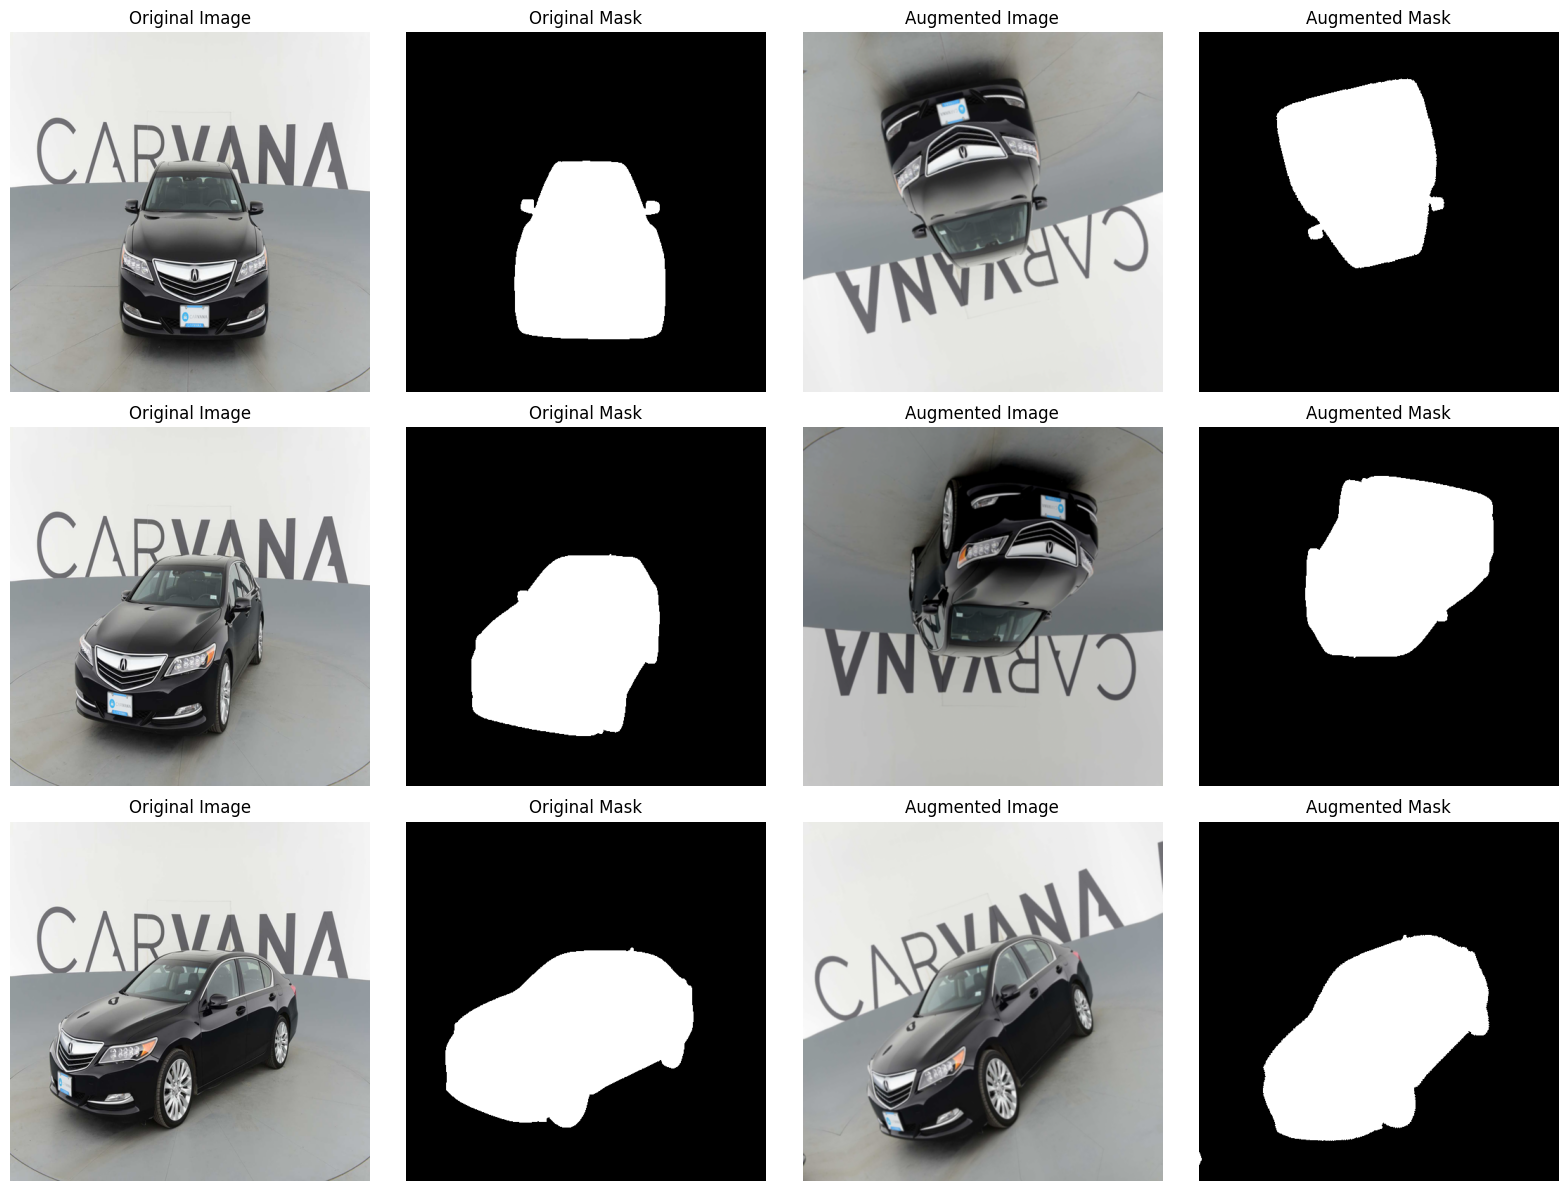

In [23]:
# Create training and validation generators
train_gen, val_gen = create_data_generators(
    images_dir=images_dir, 
    masks_dir=masks_dir,
    batch_size=8,
    target_size=(512, 512),
    validation_split=0.2
)

# Demonstrate augmentations
demonstrate_augmentation_results(images_dir, masks_dir, num_samples=3)

## 5. U-Net Architecture Implementation

1. **Encoder (Contracting Path) Design**:
   - **Input Layer**: Accept images of size (height, width, 3)
   - **Encoder Block Structure**:
     - Two 3x3 convolutions with ReLU activation
     - Batch normalization after each convolution
     - Dropout for regularization (0.1-0.2)
     - 2x2 max pooling for downsampling
   
   - **Encoder Levels**:
     - Level 1: 64 filters, input size
     - Level 2: 128 filters, 1/2 input size
     - Level 3: 256 filters, 1/4 input size
     - Level 4: 512 filters, 1/8 input size

2. **Bottleneck (Bridge) Design**:
   - Located at the lowest resolution (1/16 input size)
   - Two 3x3 convolutions with 1024 filters
   - Higher dropout rate (0.3-0.5) for regularization
   - No max pooling (preparation for upsampling)

3. **Decoder (Expanding Path) Design**:
   - **Decoder Block Structure**:
     - 2x2 transpose convolution for upsampling
     - Concatenation with corresponding encoder features (skip connections)
     - Two 3x3 convolutions with ReLU activation
     - Batch normalization and dropout
   
   - **Decoder Levels**:
     - Level 1: Upsample to 1/8, concatenate with encoder level 4
     - Level 2: Upsample to 1/4, concatenate with encoder level 3
     - Level 3: Upsample to 1/2, concatenate with encoder level 2
     - Level 4: Upsample to full size, concatenate with encoder level 1

4. **Skip Connections Implementation**:
   - Store encoder feature maps at each level
   - Concatenate along channel dimension in decoder
   - Ensure spatial dimensions match for concatenation
   - Handle any size mismatches through cropping or padding

5. **Output Layer Design**:
   - Final 1x1 convolution to reduce channels to number of classes
   - For binary segmentation: 1 output channel
   - Sigmoid activation for binary classification
   - Ensure output size matches input size

6. **Advanced Architecture Considerations**:
   - **Residual Connections**: Add within encoder/decoder blocks
   - **Attention Mechanisms**: Focus on important features
   - **Deep Supervision**: Add auxiliary outputs at multiple scales
   - **Dense Connections**: Connect all previous layers

### Architecture Benefits:
- **Skip Connections**: Preserve spatial information lost during downsampling
- **Symmetric Design**: Balanced encoder-decoder structure
- **Multi-scale Features**: Combines different levels of abstraction
- **End-to-End Training**: Single network for complete segmentation pipeline

### Implementation Tips:
- Use appropriate padding to maintain spatial dimensions
- Consider memory requirements when choosing filter numbers
- Experiment with different activation functions and normalizations
- Monitor gradient flow through the deep network

In [24]:
# ---------------------------------------------------------------------------- #
#                ENCODER BLOCK LEVEL 1 (32 FILTERS, INPUT SIZE)                #
# ---------------------------------------------------------------------------- #

inputs = Input(shape=(512,512, 3))

encoding_block_1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
encoding_block_1 = BatchNormalization()(encoding_block_1)

encoding_block_1 = Conv2D(32, 3, activation='relu', padding='same')(encoding_block_1)
encoding_block_1 = BatchNormalization()(encoding_block_1)

encoding_block_1 = Dropout(0.1)(encoding_block_1)
encoding_block_1_pooling = MaxPooling2D((2, 2))(encoding_block_1)  # Downsampling

# ---------------------------------------------------------------------------- #
#              ENCODER BLOCK LEVEL 2 (64 FILTERS, 1/2 INPUT SIZE)             #
# ---------------------------------------------------------------------------- #

encoding_block_2 = Conv2D(64, 3, activation='relu', padding='same')(encoding_block_1_pooling)
encoding_block_2 = BatchNormalization()(encoding_block_2)

encoding_block_2 = Conv2D(64, 3, activation='relu', padding='same')(encoding_block_2)
encoding_block_2 = BatchNormalization()(encoding_block_2)

encoding_block_2 = Dropout(0.1)(encoding_block_2)
encoding_block_2_pooling = MaxPooling2D((2, 2))(encoding_block_2)  # Downsampling

# ---------------------------------------------------------------------------- #
#              ENCODER BLOCK LEVEL 3 (128 FILTERS, 1/4 INPUT SIZE)             #
# ---------------------------------------------------------------------------- #

encoding_block_3 = Conv2D(128, 3, activation='relu', padding='same')(encoding_block_2_pooling)
encoding_block_3 = BatchNormalization()(encoding_block_3)

encoding_block_3 = Conv2D(128, 3, activation='relu', padding='same')(encoding_block_3)
encoding_block_3 = BatchNormalization()(encoding_block_3)

encoding_block_3 = Dropout(0.1)(encoding_block_3)
encoding_block_3_pooling = MaxPooling2D((2, 2))(encoding_block_3)  # Downsampling

# ---------------------------------------------------------------------------- #
#              ENCODER BLOCK LEVEL 4 (256 FILTERS, 1/8 INPUT SIZE)             #
# ---------------------------------------------------------------------------- #

encoding_block_4 = Conv2D(256, 3, activation='relu', padding='same')(encoding_block_3_pooling)
encoding_block_4 = BatchNormalization()(encoding_block_4)

encoding_block_4 = Conv2D(256, 3, activation='relu', padding='same')(encoding_block_4)
encoding_block_4 = BatchNormalization()(encoding_block_4)

encoding_block_4 = Dropout(0.1)(encoding_block_4)
encoding_block_4_pooling = MaxPooling2D((2, 2))(encoding_block_4)  # Downsampling


# ---------------------------------------------------------------------------- #
#                BOTTLENECK BRIDGE 512 FILTERS, 1/16 INPUT SIZE               #
# ---------------------------------------------------------------------------- #

bottleneck_bridge = Conv2D(512, 3, activation='relu', padding='same')(encoding_block_4_pooling)
bottleneck_bridge = BatchNormalization()(bottleneck_bridge)

bottleneck_bridge = Conv2D(512, 3, activation='relu', padding='same')(bottleneck_bridge)
bottleneck_bridge = BatchNormalization()(bottleneck_bridge)

bottleneck_bridge = Dropout(0.3)(bottleneck_bridge) # No downsampling after

# ---------------------------------------------------------------------------- #
#              DECODER BLOCK LEVEL 1 (256 FILTERS, 1/8 INPUT SIZE)             #
# ---------------------------------------------------------------------------- #

decoder_block_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck_bridge) 
decoder_block_1 = concatenate([decoder_block_1, encoding_block_4]) # Concatenate with Encoder Block Level 4

decoder_block_1 = Conv2D(256, 3, activation='relu', padding='same')(decoder_block_1)
decoder_block_1 = BatchNormalization()(decoder_block_1)

decoder_block_1 = Conv2D(256, 3, activation='relu', padding='same')(decoder_block_1)
decoder_block_1 = BatchNormalization()(decoder_block_1)

decoder_block_1 = Dropout(0.2)(decoder_block_1)

# ---------------------------------------------------------------------------- #
#              DECODER BLOCK LEVEL 2 (128 FILTERS, 1/4 INPUT SIZE)             #
# ---------------------------------------------------------------------------- #

decoder_block_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(decoder_block_1)
decoder_block_2 = concatenate([decoder_block_2, encoding_block_3]) # Concatenate with Encoder Block Level 3

decoder_block_2 = Conv2D(128, 3, activation='relu', padding='same')(decoder_block_2)
decoder_block_2 = BatchNormalization()(decoder_block_2)

decoder_block_2 = Conv2D(128, 3, activation='relu', padding='same')(decoder_block_2)
decoder_block_2 = BatchNormalization()(decoder_block_2)

decoder_block_2 = Dropout(0.2)(decoder_block_2)

# ---------------------------------------------------------------------------- #
#              DECODER BLOCK LEVEL 3 (64 FILTERS, 1/2 INPUT SIZE)             #
# ---------------------------------------------------------------------------- #

decoder_block_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(decoder_block_2)
decoder_block_3 = concatenate([decoder_block_3, encoding_block_2]) # Concatenate with Encoder Block Level 2

decoder_block_3 = Conv2D(64, 3, activation='relu', padding='same')(decoder_block_3)
decoder_block_3 = BatchNormalization()(decoder_block_3)

decoder_block_3 = Conv2D(64, 3, activation='relu', padding='same')(decoder_block_3)
decoder_block_3 = BatchNormalization()(decoder_block_3)

decoder_block_3 = Dropout(0.1)(decoder_block_3)

# ---------------------------------------------------------------------------- #
#                DECODER BLOCK LEVEL 4 (32 FILTERS, INPUT SIZE)                #
# ---------------------------------------------------------------------------- #

decoder_block_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(decoder_block_3)
decoder_block_4 = concatenate([decoder_block_4, encoding_block_1]) # Concatenate with Encoder Block Level 1

decoder_block_4 = Conv2D(32, 3, activation='relu', padding='same')(decoder_block_4)
decoder_block_4 = BatchNormalization()(decoder_block_4)

decoder_block_4 = Conv2D(32, 3, activation='relu', padding='same')(decoder_block_4)
decoder_block_4 = BatchNormalization()(decoder_block_4)

decoder_block_4 = Dropout(0.1)(decoder_block_4)

# ---------------------------------------------------------------------------- #
#                                 OUTPUT LAYER                                 #
# ---------------------------------------------------------------------------- #

outputs = Conv2D(1, 1, activation = 'sigmoid')(decoder_block_4)

# Create the model
model = Model(inputs = inputs, outputs = outputs)

2025-07-31 21:34:58.132477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-31 21:34:58.135426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-31 21:34:58.137498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 6. Model Compilation and Training Setup

1. **Loss Function Selection**:   
   - **Combined Loss**: Binary cross-entropy + Dice loss
     - Balances pixel-wise accuracy and overlap
     - Often provides best results for segmentation

2. **Optimizer Configuration**:
   - **Adam Optimizer**: Good default choice
     - Learning rate: 1e-3 to 1e-4
     - Beta1: 0.9, Beta2: 0.999
     - Adaptive learning rates for each parameter
      
   - **Learning Rate Scheduling**:
     - ReduceLROnPlateau: Reduce when validation loss plateaus
     - CosineAnnealingLR: Cyclical learning rate changes
     - ExponentialDecay: Gradual learning rate reduction

3. **Evaluation Metrics Setup**:
   - **IoU (Intersection over Union)**:
     - Primary metric for segmentation tasks
     - Measures overlap between prediction and ground truth
     - Range: 0 to 1 (higher is better)
   
   - **Dice Coefficient**:
     - Similar to IoU but with different mathematical formulation
     - Also measures overlap quality
     - More sensitive to small objects
   
   - **Pixel Accuracy**:
     - Percentage of correctly classified pixels
     - Can be misleading with class imbalance
   
   - **Precision and Recall**:
     - Precision: True positives / (True positives + False positives)
     - Recall: True positives / (True positives + False negatives)

4. **Callback Configuration**:
   - **ModelCheckpoint**:
     - Save best model based on validation metric
     - Monitor validation IoU or validation loss
     - Save only when improvement is detected
     - Keep backup of best weights
   
   - **EarlyStopping**:
     - Stop training when validation metric stops improving
     - Patience: 10-20 epochs
     - Restore best weights when stopping
   
   - **ReduceLROnPlateau**:
     - Reduce learning rate when training plateaus
     - Factor: 0.5 (reduce by half)
     - Patience: 5-10 epochs
     - Minimum learning rate: 1e-7
   
   - **CSVLogger**:
     - Log training metrics to CSV file
     - Useful for post-training analysis
     - Track loss and metric evolution

5. **Training Configuration**:
   - **Batch Size Selection**:
     - Balance between memory constraints and training stability
     - Typical values: 8, 16, 32 (depending on GPU memory)
     - Smaller batches may need adjusted learning rate
   
   - **Epoch Planning**:
     - Start with 50-100 epochs
     - Monitor for overfitting or underfitting
     - Adjust based on learning curves
   
   - **Validation Strategy**:
     - Use separate validation set (not used in training)
     - Evaluate every epoch
     - Monitor both loss and custom metrics

### Best Practices:
- Start with proven hyperparameters and adjust gradually
- Monitor training curves to detect overfitting early
- Use mixed precision training for memory efficiency
- Implement gradient clipping if training becomes unstable
- Save model architecture separately from weights

In [25]:
# ---------------------------------------------------------------------------- #
#                            COMBINED LOSS FUNCTION                            #
# ---------------------------------------------------------------------------- #

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice coefficient for binary segmentation
    
    Args:
        y_true: Ground truth masks
        y_pred: Predicted masks
        smooth: Smoothing factor to avoid division by zero
    
    Returns:
        Dice coefficient value
    """
    y_true_f = tf.keras.backend.flatten(y_true) #type: ignore
    y_pred_f = tf.keras.backend.flatten(y_pred) #type: ignore
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)    #type: ignore
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)    #type: ignore

def dice_loss(y_true, y_pred):
    """
    Dice loss function (1 - Dice coefficient)
    """
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(alpha=0.5):
    """
    Combined loss function: Binary Cross-Entropy + Dice Loss
    
    Args:
        alpha: Weight factor for combining losses (0.5 = equal weight)
               alpha closer to 0 = more weight to BCE
               alpha closer to 1 = more weight to Dice
    
    Returns:
        Combined loss function
    """
    def loss(y_true, y_pred):
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)  #type: ignore
        dice_loss_value = dice_loss(y_true, y_pred)
        return alpha * dice_loss_value + (1 - alpha) * bce_loss
    
    return loss

In [26]:
# ---------------------------------------------------------------------------- #
#                          LEARNING RATE SCHEDULING                            #
# ---------------------------------------------------------------------------- #

def create_learning_rate_scheduler(initial_lr=1e-3, schedule_type='plateau'):
    """
    Create different types of learning rate schedulers
    
    Args:
        initial_lr: Starting learning rate
        schedule_type: Type of scheduler ('plateau', 'exponential', 'cosine', 'step')
    
    Returns:
        Learning rate scheduler callback
    """
    
    if schedule_type == 'plateau':
        # Reduces LR when validation loss stops improving
        return callbacks.ReduceLROnPlateau(
            monitor='val_loss',           # Metric to monitor
            factor=0.5,                   # Factor to reduce LR (new_lr = lr * factor)
            patience=5,                   # Number of epochs to wait before reducing
            min_lr=1e-7,                 # Minimum learning rate    #type: ignore
            verbose=1,                    # Print message when LR is reduced
            cooldown=2                    # Epochs to wait after LR reduction
        )
    
    elif schedule_type == 'exponential':
        # Exponentially decay learning rate
        return callbacks.LearningRateScheduler(
            lambda epoch: initial_lr * (0.95 ** epoch),  # Decay by 5% each epoch
            verbose=1
        )
    
    elif schedule_type == 'cosine':
        # Cosine annealing - gradually decreases then increases
        def cosine_schedule(epoch, lr):
            import math
            epochs = 100  # Total expected epochs
            return initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / epochs))
        
        return callbacks.LearningRateScheduler(cosine_schedule, verbose=1)
    
    elif schedule_type == 'step':
        # Step decay - reduce LR at specific epochs
        def step_schedule(epoch, lr):
            if epoch < 30:
                return initial_lr
            elif epoch < 60:
                return initial_lr * 0.1
            else:
                return initial_lr * 0.01
        
        return callbacks.LearningRateScheduler(step_schedule, verbose=1)
    
    else:
        raise ValueError("Schedule type must be 'plateau', 'exponential', 'cosine', or 'step'")

In [27]:
# ---------------------------------------------------------------------------- #
#                            MODEL COMPILATION                                 #
# ---------------------------------------------------------------------------- #

def compile_model_with_combined_loss(model, learning_rate=1e-3, loss_alpha=0.5):
    """
    Compile model with combined loss and Adam optimizer
    
    Args:
        model: U-Net model to compile
        learning_rate: Initial learning rate for Adam
        loss_alpha: Weight factor for combined loss
    """
    
    # Create Adam optimizer
    optimizer = optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,              # Exponential decay rate for 1st moment estimates
        beta_2=0.999,            # Exponential decay rate for 2nd moment estimates
        epsilon=1e-7,            # Small constant for numerical stability
        amsgrad=False            # Whether to apply AMSGrad variant
    )
    
    # Create combined loss function
    loss_function = combined_loss(alpha=loss_alpha)
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[
            'accuracy',                    # Pixel accuracy
            dice_coefficient,              # Dice coefficient metric
            tf.keras.metrics.BinaryIoU()   # IoU metric #type: ignore
        ]
    )
    
    print(f"Model compiled with:")
    print(f"  - Optimizer: Adam (lr={learning_rate})")
    print(f"  - Loss: Combined BCE + Dice (alpha={loss_alpha})")
    print(f"  - Metrics: Accuracy, Dice Coefficient, IoU")

In [28]:
# ---------------------------------------------------------------------------- #
#                         TRAINING SETUP WITH CALLBACKS                        #
# ---------------------------------------------------------------------------- #

def setup_training_callbacks(model_name="unet_carvana", 
                            lr_schedule_type='plateau',
                            initial_lr=1e-3):
    """
    Setup all training callbacks including learning rate scheduling
    
    Args:
        model_name: Name for saving model files
        lr_schedule_type: Type of learning rate scheduler
        initial_lr: Initial learning rate
    
    Returns:
        List of callback objects
    """
    
    callbacks_list = []
    
    # 1. Model Checkpoint - Save best model
    checkpoint = callbacks.ModelCheckpoint(
        filepath=f'{model_name}_best.h5',
        monitor='val_binary_io_u',        # Monitor validation IoU
        mode='max',                       # Maximize IoU
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    callbacks_list.append(checkpoint)
    
    # 2. Early Stopping - Stop training if no improvement
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,                      # Wait 15 epochs before stopping
        verbose=1,
        restore_best_weights=True         # Restore best weights when stopping
    )
    callbacks_list.append(early_stop)
    
    # 3. Learning Rate Scheduler
    lr_scheduler = create_learning_rate_scheduler(
        initial_lr=initial_lr,
        schedule_type=lr_schedule_type
    )
    callbacks_list.append(lr_scheduler)
    
    # 4. CSV Logger - Log training metrics
    csv_logger = callbacks.CSVLogger(
        filename=f'{model_name}_training_log.csv',
        append=True                       # Append to existing file if it exists
    )
    callbacks_list.append(csv_logger)
    
    # 5. TensorBoard (optional) - For visualization
    tensorboard = callbacks.TensorBoard(
        log_dir=f'./logs/{model_name}',
        histogram_freq=1,                 # Log weight histograms every epoch
        write_graph=True,
        write_images=True
    )
    callbacks_list.append(tensorboard)
    
    return callbacks_list

In [29]:
compile_model_with_combined_loss(model, learning_rate=1e-3, loss_alpha=0.5)

# Setup callbacks for training
training_callbacks = setup_training_callbacks(
    model_name="unet_carvana_combined_loss",
    lr_schedule_type='plateau',  # Try 'plateau', 'exponential', 'cosine', or 'step'
    initial_lr=1e-3
)

print(f"\nTraining callbacks setup complete!")
print(f"Number of callbacks: {len(training_callbacks)}")
for i, callback in enumerate(training_callbacks):
    print(f"  {i+1}. {type(callback).__name__}")

Model compiled with:
  - Optimizer: Adam (lr=0.001)
  - Loss: Combined BCE + Dice (alpha=0.5)
  - Metrics: Accuracy, Dice Coefficient, IoU

Training callbacks setup complete!
Number of callbacks: 5
  1. ModelCheckpoint
  2. EarlyStopping
  3. ReduceLROnPlateau
  4. CSVLogger
  5. TensorBoard


## 7. Train the U-Net Model

1. **Pre-Training Preparation**:
   - Verify data generators are working correctly
   - Test model architecture with a small batch
   - Ensure all paths and dependencies are properly set
   - Clear any previous model states or cached data
   - Set up logging and monitoring systems

2. **Training Process Initiation**:
   - Start the training process using model.fit() or custom training loop
   - Monitor initial loss values to ensure proper initialization
   - Check that gradients are flowing properly (not too large or small)
   - Verify that data loading is efficient (no bottlenecks)

3. **Training Monitoring Strategy**:
   - **Real-time Metrics Tracking**:
     - Monitor training and validation loss curves
     - Track IoU and Dice coefficient progression
     - Watch for signs of overfitting (validation loss increasing)
     - Monitor learning rate changes from schedulers
   
   - **Visual Progress Monitoring**:
     - Periodically visualize predictions on validation samples
     - Compare predictions at different training stages
     - Create side-by-side comparisons of original, ground truth, and prediction
     - Save sample predictions at regular intervals

4. **Training Curve Analysis**:
   - **Healthy Training Signs**:
     - Both training and validation loss decreasing
     - Validation metrics improving steadily
     - No large spikes or instabilities
     - Learning rate reductions leading to continued improvement
   
   - **Overfitting Detection**:
     - Training loss continues to decrease while validation loss increases
     - Large gap between training and validation metrics
     - Validation metrics plateau or degrade
   
   - **Underfitting Indicators**:
     - Both training and validation loss plateau at high values
     - Model predictions look poor on validation samples
     - Metrics remain low despite adequate training time

5. **Training Optimization Strategies**:
   - **If Overfitting Occurs**:
     - Increase dropout rates
     - Add more data augmentation
     - Reduce model complexity
     - Implement early stopping
     - Use regularization techniques
   
   - **If Underfitting Occurs**:
     - Increase model capacity (more filters/layers)
     - Reduce regularization
     - Increase learning rate
     - Train for more epochs
     - Check data quality and preprocessing

6. **Progress Visualization**:
   - Create plots showing loss evolution over epochs
   - Plot IoU and Dice coefficient trends
   - Generate learning rate schedules visualization
   - Create confusion matrices for validation set
   - Show sample predictions at different training stages

7. **Checkpoint Management**:
   - Regularly save model checkpoints
   - Keep multiple backup checkpoints
   - Monitor disk space usage
   - Implement automatic cleanup of old checkpoints
   - Save best model based on validation metrics

8. **Training Completion**:
   - Allow training to complete or trigger early stopping
   - Load the best model checkpoint
   - Save final model weights and architecture
   - Document final training metrics
   - Create comprehensive training report

### Expected Training Timeline:
- **Initial epochs (1-10)**: Rapid loss decrease, basic shape learning
- **Middle epochs (10-30)**: Refinement of boundaries, metric improvement
- **Final epochs (30+)**: Fine-tuning, potential overfitting watch
- **Total time**: Several hours to days depending on hardware and dataset size

### Troubleshooting Common Issues:
- **NaN losses**: Check learning rate, data normalization, or loss function
- **Slow training**: Verify data loading efficiency, consider mixed precision
- **Memory issues**: Reduce batch size, optimize data pipeline
- **Poor convergence**: Adjust learning rate, check data quality

In [30]:
# ---------------------------------------------------------------------------- #
#                         PREPARE TRAINING VARIABLES                           #
# ---------------------------------------------------------------------------- #

# Create aliases for data generators to match training function expectations
train_generator = train_gen
val_generator = val_gen

print("✅ Data generator aliases created:")
print(f"  - train_generator: {type(train_generator).__name__}")
print(f"  - val_generator: {type(val_generator).__name__}")
print(f"  - Training batches per epoch: {len(train_generator)}")
print(f"  - Validation batches per epoch: {len(val_generator)}")
print(f"  - Batch size: {train_generator.batch_size}")
print(f"  - Target size: {train_generator.target_size}")

# Verify generators work by testing a batch
print("\n🔍 Testing data generators...")
try:
    train_batch = next(iter(train_generator))
    val_batch = next(iter(val_generator))
    
    print(f"  ✅ Training batch shape: {train_batch[0].shape} (images), {train_batch[1].shape} (masks)")
    print(f"  ✅ Validation batch shape: {val_batch[0].shape} (images), {val_batch[1].shape} (masks)")
    print("  ✅ Data generators are working correctly!")
    
except Exception as e:
    print(f"  ❌ Error testing generators: {str(e)}")
    print("  Please check your data paths and generator configuration.")

print("\n🚀 Ready for training!")

✅ Data generator aliases created:
  - train_generator: AugmentedDataGenerator
  - val_generator: AugmentedDataGenerator
  - Training batches per epoch: 508
  - Validation batches per epoch: 127
  - Batch size: 8
  - Target size: (512, 512)

🔍 Testing data generators...
  ✅ Training batch shape: (8, 512, 512, 3) (images), (8, 512, 512, 1) (masks)
  ✅ Validation batch shape: (8, 512, 512, 3) (images), (8, 512, 512, 1) (masks)
  ✅ Data generators are working correctly!

🚀 Ready for training!


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9927 - binary_io_u: 0.9789 - dice_coefficient: 0.9799 - loss: 0.0213 - val_accuracy: 0.9944 - val_binary_io_u: 0.9838 - val_dice_coefficient: 0.9842 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 19/30
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9927 - binary_io_u: 0.9784 - dice_coefficient: 0.9788 - loss: 0.0215
Epoch 19: val_binary_io_u did not improve from 0.98384

Epoch 19: val_binary_io_u did not improve from 0.98384
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - l

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9927 - binary_io_u: 0.9789 - dice_coefficient: 0.9799 - loss: 0.0213 - val_accuracy: 0.9944 - val_binary_io_u: 0.9838 - val_dice_coefficient: 0.9842 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 19/30
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9927 - binary_io_u: 0.9784 - dice_coefficient: 0.9788 - loss: 0.0215
Epoch 19: val_binary_io_u did not improve from 0.98384

Epoch 19: val_binary_io_u did not improve from 0.98384
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - l

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9927 - binary_io_u: 0.9789 - dice_coefficient: 0.9799 - loss: 0.0213 - val_accuracy: 0.9944 - val_binary_io_u: 0.9838 - val_dice_coefficient: 0.9842 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 19/30
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9927 - binary_io_u: 0.9784 - dice_coefficient: 0.9788 - loss: 0.0215
Epoch 19: val_binary_io_u did not improve from 0.98384

Epoch 19: val_binary_io_u did not improve from 0.98384
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9926 - binary_io_u: 0.9782 - dice_coefficient: 0.9789 - loss: 0.0217 - val_accuracy: 0.9950 - val_binary_io_u: 0.9856 - val_dice_coefficient: 0.9863 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 23/30
Epoch 23/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9927 - binary_io_u: 0.9783 - dice_coefficient: 0.9789 - loss: 0.0218
Epoch 23: val_binary_io_u did not improve from 0.98555

Epoch 23: val_binary_io_u did not improve from 0.98555
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 24/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 -

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9927 - binary_io_u: 0.9789 - dice_coefficient: 0.9799 - loss: 0.0213 - val_accuracy: 0.9944 - val_binary_io_u: 0.9838 - val_dice_coefficient: 0.9842 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 19/30
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9927 - binary_io_u: 0.9784 - dice_coefficient: 0.9788 - loss: 0.0215
Epoch 19: val_binary_io_u did not improve from 0.98384

Epoch 19: val_binary_io_u did not improve from 0.98384
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9926 - binary_io_u: 0.9782 - dice_coefficient: 0.9789 - loss: 0.0217 - val_accuracy: 0.9950 - val_binary_io_u: 0.9856 - val_dice_coefficient: 0.9863 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 23/30
Epoch 23/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9927 - binary_io_u: 0.9783 - dice_coefficient: 0.9789 - loss: 0.0218
Epoch 23: val_binary_io_u did not improve from 0.98555

Epoch 23: val_binary_io_u did not improve from 0.98555
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 24/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 -

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9927 - binary_io_u: 0.9789 - dice_coefficient: 0.9799 - loss: 0.0213 - val_accuracy: 0.9944 - val_binary_io_u: 0.9838 - val_dice_coefficient: 0.9842 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 19/30
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9927 - binary_io_u: 0.9784 - dice_coefficient: 0.9788 - loss: 0.0215
Epoch 19: val_binary_io_u did not improve from 0.98384

Epoch 19: val_binary_io_u did not improve from 0.98384
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9926 - binary_io_u: 0.9782 - dice_coefficient: 0.9789 - loss: 0.0217 - val_accuracy: 0.9950 - val_binary_io_u: 0.9856 - val_dice_coefficient: 0.9863 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 23/30
Epoch 23/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9927 - binary_io_u: 0.9783 - dice_coefficient: 0.9789 - loss: 0.0218
Epoch 23: val_binary_io_u did not improve from 0.98555

Epoch 23: val_binary_io_u did not improve from 0.98555
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 24/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 -

100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.9944 - binary_io_u: 0.9834 - dice_coefficient: 0.9838 - loss: 0.0163 - val_accuracy: 0.9958 - val_binary_io_u: 0.9877 - val_dice_coefficient: 0.9888 - val_loss: 0.0116 - learning_rate: 5.0000e-04
Epoch 30/30
Epoch 30/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.9947 - binary_io_u: 0.9840 - dice_coefficient: 0.9844 - loss: 0.0157
Epoch 30: val_binary_io_u did not improve from 0.98771

Epoch 30: val_binary_io_u did not improve from 0.98771
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9950 - binary_io_u: 0.9843 - dice_coefficient: 0.9845 - loss: 0.0151 - val_accuracy: 0.9956 - val_binary_io_u: 0.9871 - val_dice_coefficient: 0.9884 - val_loss: 0.0122 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 29.
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9950 - binary_io_u: 0.9843 - dice_coefficient: 0.9845 - loss: 0.0151 - val_accuracy: 0.9956 - val_binary_io_u: 0.987

🔍 Checking training prerequisites...
  ✅ model: Found
  ✅ train_generator: Found
  ✅ val_generator: Found
  ✅ training_callbacks: Found
✅ All prerequisites found! Ready for training.

🚀 Starting U-Net Training Process...
                    STARTING U-NET TRAINING
Training Configuration:
  - Epochs: 30
  - Steps per epoch: 100
  - Validation steps: 20
  - Callbacks: 5
  - Start time: 2025-07-31 21:34:59
Epoch 1/30
Epoch 1/30


I0000 00:00:1753994105.179390   16663 service.cc:145] XLA service 0x7471d00420e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753994105.179422   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:05.410226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:06.232962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-07-31 21:35:35.025954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocato

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8588 - binary_io_u: 0.6997 - dice_coefficient: 0.6257 - loss: 0.3862
Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5

Epoch 1: val_binary_io_u improved from None to 0.39145, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:19.434854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.9164 - binary_io_u: 0.7914 - dice_coefficient: 0.7330 - loss: 0.2665 - val_accuracy: 0.7829 - val_binary_io_u: 0.3914 - val_dice_coefficient: 0.0511 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 2/30
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9616 - binary_io_u: 0.8926 - dice_coefficient: 0.8680 - loss: 0.1265
Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5

Epoch 2: val_binary_io_u improved from 0.39145 to 0.39151, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:36:46.123557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9687 - binary_io_u: 0.9111 - dice_coefficient: 0.8936 - loss: 0.1024 - val_accuracy: 0.7829 - val_binary_io_u: 0.3915 - val_dice_coefficient: 0.0046 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/30
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9765 - binary_io_u: 0.9326 - dice_coefficient: 0.9254 - loss: 0.0728
Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5

Epoch 3: val_binary_io_u improved from 0.39151 to 0.46577, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:12.691211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9771 - binary_io_u: 0.9338 - dice_coefficient: 0.9277 - loss: 0.0705 - val_accuracy: 0.8102 - val_binary_io_u: 0.4658 - val_dice_coefficient: 0.2205 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 4/30
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9781 - binary_io_u: 0.9366 - dice_coefficient: 0.9330 - loss: 0.0659
Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5

Epoch 4: val_binary_io_u improved from 0.46577 to 0.55202, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:37:39.548648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9796 - binary_io_u: 0.9409 - dice_coefficient: 0.9377 - loss: 0.0619 - val_accuracy: 0.8417 - val_binary_io_u: 0.5520 - val_dice_coefficient: 0.4185 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 5/30
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9840 - binary_io_u: 0.9534 - dice_coefficient: 0.9517 - loss: 0.0487
Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5

Epoch 5: val_binary_io_u improved from 0.55202 to 0.82340, saving model to unet_carvana_combined_loss_best.h5


2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.
2025-07-31 21:38:06.048785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.9848 - binary_io_u: 0.9559 - dice_coefficient: 0.9546 - loss: 0.0456 - val_accuracy: 0.9383 - val_binary_io_u: 0.8234 - val_dice_coefficient: 0.8179 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/30
Epoch 6/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9862 - binary_io_u: 0.9602 - dice_coefficient: 0.9589 - loss: 0.0403
Epoch 6: val_binary_io_u did not improve from 0.82340

Epoch 6: val_binary_io_u did not improve from 0.82340
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9865 - binary_io_u: 0.9609 - dice_coefficient: 0.9593 - loss: 0.0400 - val_accuracy: 0.9138 - val_binary_io_u: 0.7519 - val_dice_coefficient: 0.7380 - val_loss: 0.3032 - learnin

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9853 - binary_io_u: 0.9574 - dice_coefficient: 0.9568 - loss: 0.0437 - val_accuracy: 0.9794 - val_binary_io_u: 0.9402 - val_dice_coefficient: 0.9446 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 8/30
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9863 - binary_io_u: 0.9601 - dice_coefficient: 0.9598 - loss: 0.0406
Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5

Epoch 8: val_binary_io_u improved from 0.94025 to 0.96718, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9867 - binary_io_u: 0.9613 - dice_coefficient: 0.9612 - loss: 0.0394 - val_accuracy: 0.9885 - val_binary_io_u: 0.9672 - val_dice_coefficient: 0.9683 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 9/30
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9876 - binary_io_u: 0.9631 - dice_coefficient: 0.9628 - loss: 0.0374
Epoch 9: val_binary_io_u did not improve from 0.96718

Epoch 9: val_binary_io_u did not improve from 0.96718
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - accuracy: 0.9876 - binary_io_u: 0.9633 - dice_coefficient: 0.9632 - loss: 0.0371 - val_accuracy: 0.8623 - val_binary_io_u: 0.7169 - val_dice_coefficient: 0.7511 - val_loss: 0.7710 - lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9909 - binary_io_u: 0.9727 - dice_coefficient: 0.9726 - loss: 0.0274 - val_accuracy: 0.9897 - val_binary_io_u: 0.9703 - val_dice_coefficient: 0.9722 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 13/30
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9912 - binary_io_u: 0.9742 - dice_coefficient: 0.9745 - loss: 0.0262
Epoch 13: val_binary_io_u did not improve from 0.97034

Epoch 13: val_binary_io_u did not improve from 0.97034
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 14/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9910 - binary_io_u: 0.9736 - dice_coefficient: 0.9740 - loss: 0.0267 - val_accuracy: 0.9576 - val_binary_io_u: 0.8781 - val_dice_coefficient: 0.8820 - val_loss: 0.1320 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9923 - binary_io_u: 0.9771 - dice_coefficient: 0.9776 - loss: 0.0228 - val_accuracy: 0.9933 - val_binary_io_u: 0.9807 - val_dice_coefficient: 0.9824 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 18/30
Epoch 18/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9922 - binary_io_u: 0.9779 - dice_coefficient: 0.9792 - loss: 0.0228
Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5

Epoch 18: val_binary_io_u improved from 0.98075 to 0.98384, saving model to unet_carvana_combined_loss_best.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9927 - binary_io_u: 0.9789 - dice_coefficient: 0.9799 - loss: 0.0213 - val_accuracy: 0.9944 - val_binary_io_u: 0.9838 - val_dice_coefficient: 0.9842 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 19/30
Epoch 19/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9927 - binary_io_u: 0.9784 - dice_coefficient: 0.9788 - loss: 0.0215
Epoch 19: val_binary_io_u did not improve from 0.98384

Epoch 19: val_binary_io_u did not improve from 0.98384
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 20/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.9923 - binary_io_u: 0.9774 - dice_coefficient: 0.9779 - loss: 0.0226 - val_accuracy: 0.9939 - val_binary_io_u: 0.9823 - val_dice_coefficient: 0.9836 - val_loss: 0.0172 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9926 - binary_io_u: 0.9782 - dice_coefficient: 0.9789 - loss: 0.0217 - val_accuracy: 0.9950 - val_binary_io_u: 0.9856 - val_dice_coefficient: 0.9863 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 23/30
Epoch 23/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9927 - binary_io_u: 0.9783 - dice_coefficient: 0.9789 - loss: 0.0218
Epoch 23: val_binary_io_u did not improve from 0.98555

Epoch 23: val_binary_io_u did not improve from 0.98555
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 24/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9909 - binary_io_u: 0.9730 - dice_coefficient: 0.9739 - loss: 0.0273 - val_accuracy: 0.9694 - val_binary_io_u: 0.9164 - val_dice_coefficient: 0.9242 - val_loss: 0.0895 -

100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.9944 - binary_io_u: 0.9834 - dice_coefficient: 0.9838 - loss: 0.0163 - val_accuracy: 0.9958 - val_binary_io_u: 0.9877 - val_dice_coefficient: 0.9888 - val_loss: 0.0116 - learning_rate: 5.0000e-04
Epoch 30/30
Epoch 30/30
  8/100 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.9947 - binary_io_u: 0.9840 - dice_coefficient: 0.9844 - loss: 0.0157
Epoch 30: val_binary_io_u did not improve from 0.98771

Epoch 30: val_binary_io_u did not improve from 0.98771
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9950 - binary_io_u: 0.9843 - dice_coefficient: 0.9845 - loss: 0.0151 - val_accuracy: 0.9956 - val_binary_io_u: 0.9871 - val_dice_coefficient: 0.9884 - val_loss: 0.0122 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 29.
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9950 - binary_io_u: 0.9843 - dice_coefficient: 0.9845 - loss: 0.0151 - val_accuracy: 0.9956 - val_binary_io_u: 0.987

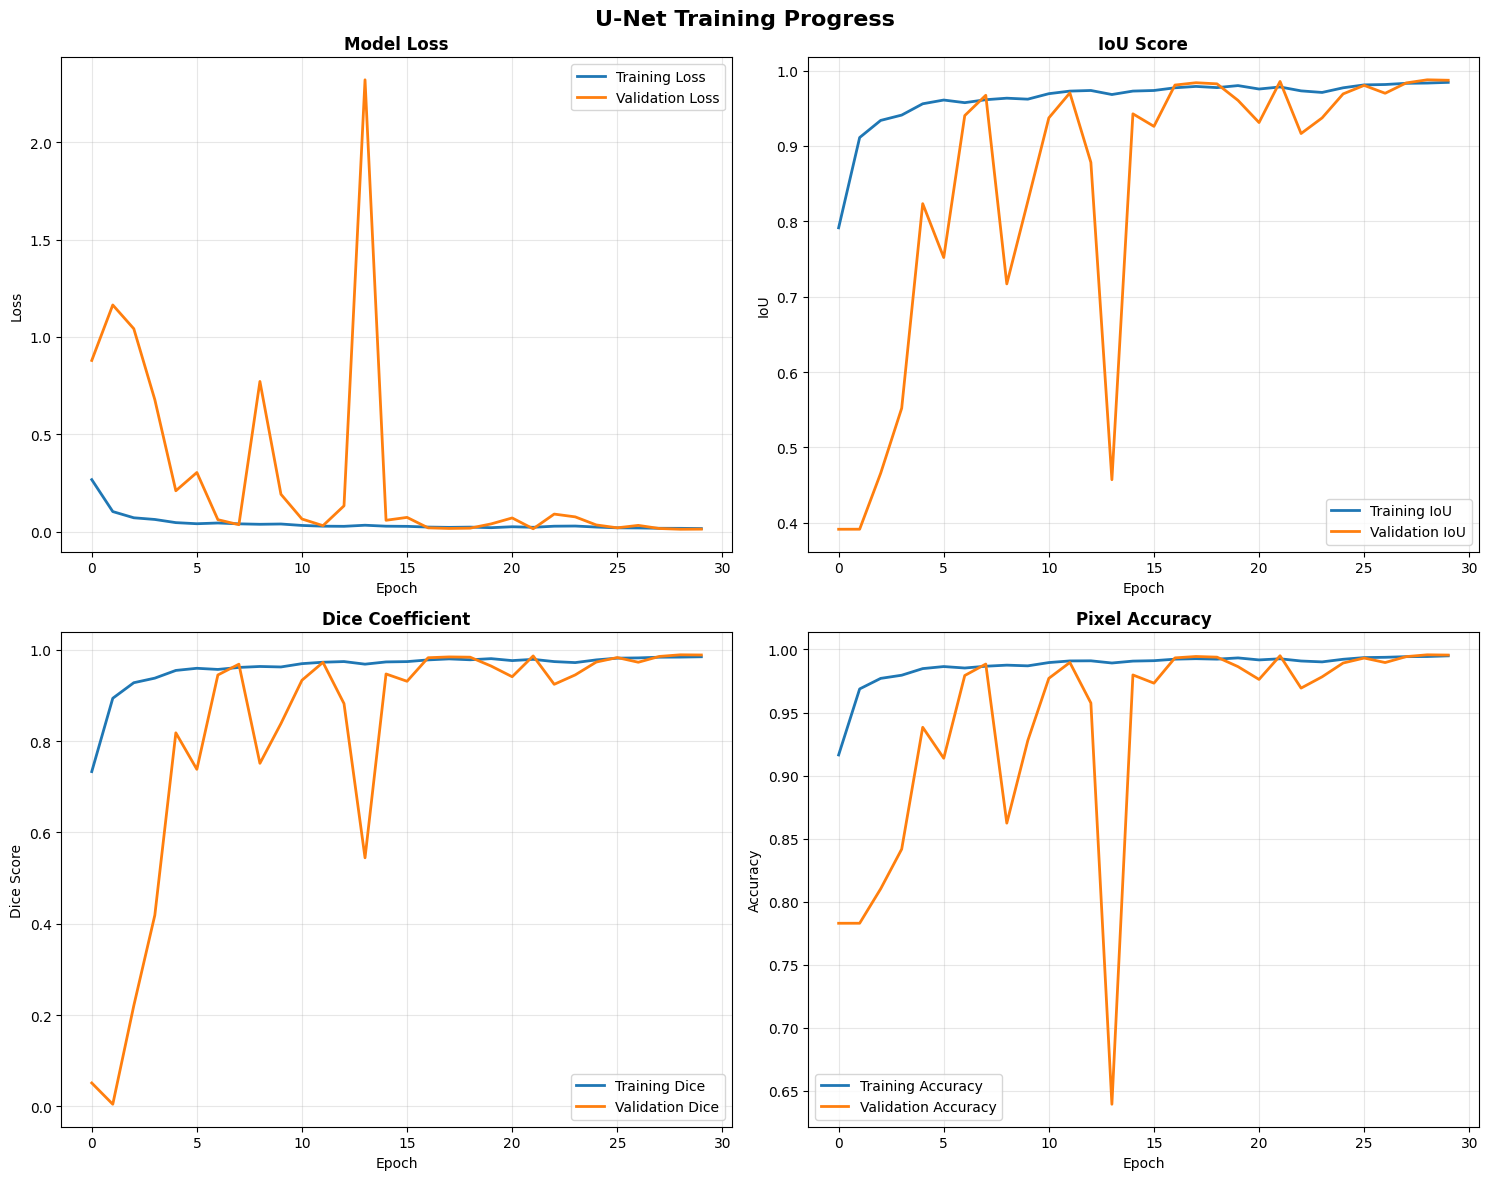


🔍 Monitoring sample predictions...

❌ Training failed: 'AugmentedDataGenerator' object is not an iterator
Please check the error message above and fix any issues.


In [ ]:
# ---------------------------------------------------------------------------- #
#                            TRAIN THE U-NET MODEL                             #
# ---------------------------------------------------------------------------- #

import time
from datetime import datetime

# -------------------------- TRAINING PREREQUISITES -------------------------- #
def check_training_prerequisites():
    """
    Check if all required variables are defined before training
    """
    required_vars = {
        'model': 'U-Net model (from section 5)',
        'train_generator': 'Training data generator (from section 4)',
        'val_generator': 'Validation data generator (from section 4)',
        'training_callbacks': 'Training callbacks (from section 6)'
    }
    
    missing_vars = []
    for var_name, description in required_vars.items():
        if var_name not in globals():
            missing_vars.append(f"  ❌ {var_name}: {description}")
        else:
            print(f"  ✅ {var_name}: Found")
    
    if missing_vars:
        print("⚠️  MISSING VARIABLES - Please run these sections first:")
        for missing in missing_vars:
            print(missing)
        print("\nTo fix this:")
        print("1. Run all cells in order from the beginning")
        print("2. Make sure sections 1-6 are executed successfully")
        print("3. Then re-run this training cell")
        return False
    
    print("✅ All prerequisites found! Ready for training.")
    return True
# ---------------------------------------------------------------------------- #

# ------------------------------ MODEL TRAINING ------------------------------ #
def train_unet_model(model, train_generator, val_generator, 
                     epochs=50, steps_per_epoch=100, validation_steps=20,
                     callbacks_list=None, save_history=True):
    """
    Train the U-Net model with comprehensive monitoring
    
    Args:
        model: Compiled U-Net model
        train_generator: Training data generator
        val_generator: Validation data generator
        epochs: Number of training epochs
        steps_per_epoch: Steps per epoch for training
        validation_steps: Steps for validation
        callbacks_list: List of callbacks for training
        save_history: Whether to save training history
    
    Returns:
        Training history object
    """
    
    print("="*70)
    print("                    STARTING U-NET TRAINING")
    print("="*70)
    print(f"Training Configuration:")
    print(f"  - Epochs: {epochs}")
    print(f"  - Steps per epoch: {steps_per_epoch}")
    print(f"  - Validation steps: {validation_steps}")
    print(f"  - Callbacks: {len(callbacks_list) if callbacks_list else 0}")
    print(f"  - Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*70)
    
    # Record start time
    start_time = time.time()
    
    try:
        # Start training - removed workers and use_multiprocessing parameters
        history = model.fit(
            train_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_generator,
            validation_steps=validation_steps,
            callbacks=callbacks_list,
            verbose=1
        )
        
        # Calculate training time
        end_time = time.time()
        training_time = end_time - start_time
        
        print("\n" + "="*70)
        print("                    TRAINING COMPLETED")
        print("="*70)
        print(f"Total training time: {training_time/3600:.2f} hours")
        print(f"Average time per epoch: {training_time/epochs:.2f} seconds")
        print("="*70)
        
        # Save training history if requested
        if save_history:
            import pickle
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            history_filename = f'training_history_{timestamp}.pkl'
            
            with open(history_filename, 'wb') as f:
                pickle.dump(history.history, f)
            print(f"Training history saved to: {history_filename}")
        
        return history
        
    except Exception as e:
        print(f"\n⚠️  TRAINING ERROR: {str(e)}")
        print("Please check your configuration and try again.")
        raise
# ---------------------------------------------------------------------------- #

# ---------------------- VISUALISE THE TRAINING PROGRESS --------------------- #
def visualize_training_progress(history, save_plots=True):
    """
    Create comprehensive visualizations of training progress
    
    Args:
        history: Training history object from model.fit()
        save_plots: Whether to save plots to files
    """
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('U-Net Training Progress', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss curves
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: IoU scores
    if 'binary_io_u' in history.history:
        axes[0, 1].plot(history.history['binary_io_u'], label='Training IoU', linewidth=2)
        axes[0, 1].plot(history.history['val_binary_io_u'], label='Validation IoU', linewidth=2)
        axes[0, 1].set_title('IoU Score', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('IoU')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Dice coefficient
    if 'dice_coefficient' in history.history:
        axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice', linewidth=2)
        axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice', linewidth=2)
        axes[1, 0].set_title('Dice Coefficient', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Dice Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Accuracy
    if 'accuracy' in history.history:
        axes[1, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        axes[1, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        axes[1, 1].set_title('Pixel Accuracy', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plots:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        plot_filename = f'training_progress_{timestamp}.png'
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Training progress plot saved to: {plot_filename}")
    
    plt.show()
# ---------------------------------------------------------------------------- #

# ----------------------- MONITOR TRAINING PREDICTIONS ----------------------- #
def monitor_training_predictions(model, val_generator, save_samples=True):
    """
    Generate and visualize sample predictions during training
    
    Args:
        model: Trained model
        val_generator: Validation data generator
        save_samples: Whether to save sample images
    """
    
    # Get a batch of validation data
    val_batch = next(val_generator)
    images, true_masks = val_batch
    
    # Generate predictions
    predictions = model.predict(images)
    
    # Select first few samples for visualization
    num_samples = min(4, len(images))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    fig.suptitle('Training Progress - Sample Predictions', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f'Sample {i+1} - Original')
        axes[i, 0].axis('off')
        
        # True mask
        axes[i, 1].imshow(true_masks[i], cmap='gray')
        axes[i, 1].set_title(f'Sample {i+1} - True Mask')
        axes[i, 1].axis('off')
        
        # Predicted mask
        pred_mask = (predictions[i] > 0.5).astype(np.uint8)
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f'Sample {i+1} - Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    
    # Save samples if requested
    if save_samples:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        sample_filename = f'training_samples_{timestamp}.png'
        plt.savefig(sample_filename, dpi=300, bbox_inches='tight')
        print(f"Sample predictions saved to: {sample_filename}")
    
    plt.show()
# ---------------------------------------------------------------------------- #

# ---------------------------------------------------------------------------- #
#                         EXECUTE TRAINING PROCESS                             #
# ---------------------------------------------------------------------------- #

print("🔍 Checking training prerequisites...")

# Check if all required variables are available
if check_training_prerequisites():
    print("\n🚀 Starting U-Net Training Process...")
    
    try:
        # Train the model
        training_history = train_unet_model(
            model=model,
            train_generator=train_generator,
            val_generator=val_generator,
            epochs=50,                    # Adjust based on your needs
            steps_per_epoch=100,          # Adjust based on dataset size
            validation_steps=20,          # Adjust based on validation set size
            callbacks_list=training_callbacks,
            save_history=True
        )

        print("\n📊 Generating training visualizations...")

        # Visualize training progress
        visualize_training_progress(training_history, save_plots=True)

        print("\n🔍 Monitoring sample predictions...")

        # Monitor training predictions
        monitor_training_predictions(model, val_generator, save_samples=True)

        print("\n✅ Training process completed successfully!")
        print("\nNext steps:")
        print("  1. Review training curves for overfitting/underfitting")
        print("  2. Examine sample predictions for quality assessment")
        print("  3. Proceed to comprehensive model evaluation")
        print("  4. Consider hyperparameter tuning if needed")
        
    except Exception as e:
        print(f"\n❌ Training failed: {str(e)}")
        print("Please check the error message above and fix any issues.")

else:
    print("\n📝 To run training successfully:")
    print("1. Execute all notebook cells from the beginning (Ctrl+Shift+F10)")
    print("2. Or run cells 1-46 individually to set up all prerequisites")
    print("3. Then re-run this training cell")

## 8. Model Evaluation and Metrics

1. **Load Best Model**:
   - Load the model checkpoint with the best validation performance
   - Verify model architecture is intact
   - Ensure proper weight loading without errors
   - Test model with a sample input to confirm functionality

2. **Comprehensive Metric Calculation**:
   
   **A. IoU (Intersection over Union)**:
   - Calculate for each image in validation/test set
   - Formula: IoU = (True Positives) / (True Positives + False Positives + False Negatives)
   - Compute mean IoU across all test images
   - Analyze IoU distribution and identify outliers
   
   **B. Dice Coefficient**:
   - Calculate pixel-wise Dice score for each prediction
   - Formula: Dice = 2 * (True Positives) / (2 * True Positives + False Positives + False Negatives)
   - Report mean and standard deviation across test set
   - Compare with IoU results for consistency
   
   **C. Pixel Accuracy**:
   - Calculate percentage of correctly classified pixels
   - Formula: Accuracy = (True Positives + True Negatives) / Total Pixels
   - Note limitations due to class imbalance
   
   **D. Precision and Recall**:
   - Precision = True Positives / (True Positives + False Positives)
   - Recall = True Positives / (True Positives + False Negatives)
   - Calculate F1-score: 2 * (Precision * Recall) / (Precision + Recall)

3. **Confusion Matrix Analysis**:
   - Create pixel-level confusion matrix
   - Visualize as heatmap for easy interpretation
   - Calculate additional metrics from confusion matrix:
     - Specificity (True Negative Rate)
     - False Positive Rate
     - False Negative Rate
   - Analyze class-wise performance

4. **Error Analysis**:
   - **Identify Failure Cases**:
     - Images with lowest IoU scores
     - Common failure patterns (shadows, reflections, similar colors)
     - Challenging scenarios (partial occlusion, complex backgrounds)
   
   - **Boundary Analysis**:
     - Evaluate performance at object boundaries
     - Measure boundary precision and recall
     - Identify systematic boundary errors
   
   - **Size-based Analysis**:
     - Performance on small vs. large objects
     - Correlation between object size and accuracy
     - Identify size-related biases

5. **Comparative Analysis**:
   - **Baseline Comparison**:
     - Compare against simple threshold-based methods
     - Benchmark against other segmentation algorithms
     - Document improvement over baseline approaches
   
   - **Ablation Studies**:
     - Impact of different loss functions
     - Effect of data augmentation strategies
     - Skip connection importance analysis
     - Architecture component contributions

6. **Statistical Significance Testing**:
   - Perform statistical tests on metric distributions
   - Calculate confidence intervals for mean metrics
   - Test for significant differences between model variants
   - Report statistical significance of improvements

7. **Visualization of Results**:
   - Create metric distribution histograms
   - Plot correlation between different metrics
   - Generate box plots for metric comparisons
   - Create scatter plots of metrics vs. image characteristics

8. **Performance Benchmarking**:
   - **Speed Analysis**:
     - Measure inference time per image
     - Analyze memory usage during inference
     - Compare with other model architectures
   
   - **Scalability Testing**:
     - Performance on different image sizes
     - Batch processing efficiency
     - GPU vs. CPU inference comparison

9. **Model Robustness Evaluation**:
   - Test on images with different characteristics:
     - Various lighting conditions
     - Different car colors and types
     - Diverse backgrounds
     - Different image qualities
   
   - **Generalization Assessment**:
     - Performance on held-out test set
     - Cross-validation results
     - Sensitivity to hyperparameter changes

### Expected Performance Benchmarks:
- **Good IoU**: > 0.85 for car segmentation
- **Excellent IoU**: > 0.90
- **Dice Coefficient**: Should be similar to IoU values
- **Pixel Accuracy**: Often > 0.95 but can be misleading
- **Processing Time**: < 100ms per image for real-time applications

### Documentation Requirements:
- Create comprehensive evaluation report
- Include visualizations of all key metrics
- Document methodology and assumptions
- Provide recommendations for model improvement

In [32]:
# Define custom objects for model loading
# This is required when loading a model that uses custom loss functions or metrics
custom_objects = {
    'dice_coefficient': dice_coefficient,
    'dice_loss': dice_loss,
    'combined_loss': combined_loss,
    'loss': combined_loss(alpha=0.5)  # If the model was compiled with alpha=0.5
}

print("✓ Custom objects dictionary created for model loading")
print("Custom functions available:", list(custom_objects.keys()))

✓ Custom objects dictionary created for model loading
Custom functions available: ['dice_coefficient', 'dice_loss', 'combined_loss', 'loss']


In [33]:
# Test Prediction and Comprehensive Performance Analysis
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the best trained model
print("Loading the best trained model...")
try:
    # Try loading the model saved during training
    model = tf.keras.models.load_model(
        'unet_carvana_combined_loss_best.h5',
        custom_objects=custom_objects
    )
    print("✓ Model loaded successfully!")
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file exists and is accessible.")

Loading the best trained model...


Loading the best trained model...


Loading the best trained model...


✓ Model loaded successfully!
Model input shape: (None, 512, 512, 3)
Model output shape: (None, 512, 512, 1)


In [34]:
# Prediction Functions
def preprocess_image_for_prediction(image_path, target_size=(512, 512)):
    """
    Preprocess image for model prediction
    """
    # Load and resize image
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size, Image.Resampling.LANCZOS)
    
    # Convert to numpy array and normalize
    image_array = np.array(image, dtype=np.float32) / 255.0
    
    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array, image

def predict_mask(model, image_array, threshold=0.5):
    """
    Generate mask prediction from model
    """
    # Get prediction
    prediction = model.predict(image_array, verbose=0)
    
    # Apply threshold to get binary mask
    binary_mask = (prediction[0, :, :, 0] > threshold).astype(np.uint8)
    
    return prediction[0, :, :, 0], binary_mask

def postprocess_mask(mask, morphology_operations=True):
    """
    Apply post-processing to improve mask quality
    """
    if morphology_operations:
        # Remove noise with morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Prepare test dataset
print("Preparing test dataset...")

# Get test images (using validation set since we don't have separate test labels)
test_images_dir = "carvana-dataset/train/"
test_masks_dir = "carvana-dataset/train_masks/"

# Get list of test images (last 200 images from train set as test)
all_images = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')]
all_images.sort()

# Use last 200 images as test set
test_images = all_images[-200:]
print(f"Selected {len(test_images)} images for testing")

# Verify corresponding masks exist
test_image_mask_pairs = []
for img_file in test_images:
    mask_file = img_file.replace('.jpg', '_mask.gif')
    mask_path = os.path.join(test_masks_dir, mask_file)
    img_path = os.path.join(test_images_dir, img_file)
    
    if os.path.exists(mask_path) and os.path.exists(img_path):
        test_image_mask_pairs.append((img_path, mask_path))

print(f"Found {len(test_image_mask_pairs)} valid test image-mask pairs")

Preparing test dataset...
Selected 200 images for testing
Found 200 valid test image-mask pairs
Selected 200 images for testing
Found 200 valid test image-mask pairs


In [ ]:
# Batch Prediction on Test Set
print("Starting batch prediction on test set...")

predictions_data = []
batch_size = 8  # Adjust based on memory constraints

for i in tqdm.tqdm(range(0, len(test_image_mask_pairs), batch_size), desc="Predicting"):
    batch_pairs = test_image_mask_pairs[i:i+batch_size]
    
    for img_path, mask_path in batch_pairs:
        try:
            # Load and preprocess image
            image_array, original_image = preprocess_image_for_prediction(img_path)
            
            # Load ground truth mask
            gt_mask = Image.open(mask_path).convert('L')
            gt_mask = gt_mask.resize((512, 512), Image.Resampling.NEAREST)
            gt_mask_array = np.array(gt_mask) / 255.0  # Normalize to 0-1
            gt_mask_binary = (gt_mask_array > 0.5).astype(np.uint8)
            
            # Generate prediction
            pred_probability, pred_binary = predict_mask(model, image_array)
            
            # Apply post-processing
            pred_binary_processed = postprocess_mask(pred_binary)
            
            # Store results
            predictions_data.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'image_name': os.path.basename(img_path),
                'original_image': original_image,
                'gt_mask': gt_mask_binary,
                'pred_probability': pred_probability,
                'pred_binary': pred_binary,
                'pred_binary_processed': pred_binary_processed
            })
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

print(f"Successfully processed {len(predictions_data)} images")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(predictions_data)
print(f"Created results DataFrame with {len(results_df)} entries")

Starting batch prediction on test set...


Starting batch prediction on test set...


Predicting:  48%|████▊     | 12/25 [00:10<00:09,  1.36it/s]

In [ ]:
# Comprehensive Performance Metrics Calculation

def calculate_iou(pred_mask, true_mask):
    """Calculate Intersection over Union (IoU)"""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    if union == 0:
        return 1.0  # Perfect score when both masks are empty
    return intersection / union

def calculate_dice_coefficient(pred_mask, true_mask):
    """Calculate Dice Coefficient"""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    total = pred_mask.sum() + true_mask.sum()
    if total == 0:
        return 1.0  # Perfect score when both masks are empty
    return (2.0 * intersection) / total

def calculate_pixel_accuracy(pred_mask, true_mask):
    """Calculate Pixel Accuracy"""
    correct_pixels = np.sum(pred_mask == true_mask)
    total_pixels = pred_mask.size
    return correct_pixels / total_pixels

def calculate_precision_recall_f1(pred_mask, true_mask):
    """Calculate Precision, Recall, and F1 Score"""
    tp = np.logical_and(pred_mask == 1, true_mask == 1).sum()
    fp = np.logical_and(pred_mask == 1, true_mask == 0).sum()
    fn = np.logical_and(pred_mask == 0, true_mask == 1).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

def calculate_boundary_accuracy(pred_mask, true_mask, tolerance=2):
    """Calculate boundary accuracy within tolerance"""
    # Find edges
    pred_edges = cv2.Canny((pred_mask * 255).astype(np.uint8), 50, 150)
    true_edges = cv2.Canny((true_mask * 255).astype(np.uint8), 50, 150)
    
    # Dilate true edges for tolerance
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tolerance*2+1, tolerance*2+1))
    true_edges_dilated = cv2.dilate(true_edges, kernel, iterations=1)
    
    # Calculate boundary accuracy
    correct_boundary = np.logical_and(pred_edges > 0, true_edges_dilated > 0).sum()
    total_pred_boundary = (pred_edges > 0).sum()
    
    if total_pred_boundary == 0:
        return 1.0 if (true_edges > 0).sum() == 0 else 0.0
    
    return correct_boundary / total_pred_boundary

# Calculate metrics for all predictions
print("Calculating comprehensive performance metrics...")

metrics_data = []

for idx, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Computing metrics"):
    gt_mask = row['gt_mask']
    pred_binary = row['pred_binary']
    pred_processed = row['pred_binary_processed']
    
    # Calculate metrics for raw prediction
    iou_raw = calculate_iou(pred_binary, gt_mask)
    dice_raw = calculate_dice_coefficient(pred_binary, gt_mask)
    pixel_acc_raw = calculate_pixel_accuracy(pred_binary, gt_mask)
    precision_raw, recall_raw, f1_raw = calculate_precision_recall_f1(pred_binary, gt_mask)
    boundary_acc_raw = calculate_boundary_accuracy(pred_binary, gt_mask)
    
    # Calculate metrics for processed prediction
    iou_processed = calculate_iou(pred_processed, gt_mask)
    dice_processed = calculate_dice_coefficient(pred_processed, gt_mask)
    pixel_acc_processed = calculate_pixel_accuracy(pred_processed, gt_mask)
    precision_processed, recall_processed, f1_processed = calculate_precision_recall_f1(pred_processed, gt_mask)
    boundary_acc_processed = calculate_boundary_accuracy(pred_processed, gt_mask)
    
    metrics_data.append({
        'image_name': row['image_name'],
        'iou_raw': iou_raw,
        'dice_raw': dice_raw,
        'pixel_accuracy_raw': pixel_acc_raw,
        'precision_raw': precision_raw,
        'recall_raw': recall_raw,
        'f1_raw': f1_raw,
        'boundary_accuracy_raw': boundary_acc_raw,
        'iou_processed': iou_processed,
        'dice_processed': dice_processed,
        'pixel_accuracy_processed': pixel_acc_processed,
        'precision_processed': precision_processed,
        'recall_processed': recall_processed,
        'f1_processed': f1_processed,
        'boundary_accuracy_processed': boundary_acc_processed,
        'car_pixels_gt': gt_mask.sum(),
        'car_pixels_pred': pred_binary.sum(),
        'car_pixels_pred_processed': pred_processed.sum(),
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)
print("✓ Metrics calculation completed!")

# Display summary statistics
print("\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset Statistics:")
print(f"• Total test images: {len(metrics_df)}")
print(f"• Average car pixels per image: {metrics_df['car_pixels_gt'].mean():.0f}")
print(f"• Car pixel coverage: {(metrics_df['car_pixels_gt'].mean() / (512*512)) * 100:.2f}%")

print(f"\nRAW PREDICTIONS PERFORMANCE:")
print(f"• Mean IoU: {metrics_df['iou_raw'].mean():.4f} ± {metrics_df['iou_raw'].std():.4f}")
print(f"• Mean Dice: {metrics_df['dice_raw'].mean():.4f} ± {metrics_df['dice_raw'].std():.4f}")
print(f"• Mean Pixel Accuracy: {metrics_df['pixel_accuracy_raw'].mean():.4f} ± {metrics_df['pixel_accuracy_raw'].std():.4f}")
print(f"• Mean Precision: {metrics_df['precision_raw'].mean():.4f} ± {metrics_df['precision_raw'].std():.4f}")
print(f"• Mean Recall: {metrics_df['recall_raw'].mean():.4f} ± {metrics_df['recall_raw'].std():.4f}")
print(f"• Mean F1-Score: {metrics_df['f1_raw'].mean():.4f} ± {metrics_df['f1_raw'].std():.4f}")
print(f"• Mean Boundary Accuracy: {metrics_df['boundary_accuracy_raw'].mean():.4f} ± {metrics_df['boundary_accuracy_raw'].std():.4f}")

print(f"\nPOST-PROCESSED PREDICTIONS PERFORMANCE:")
print(f"• Mean IoU: {metrics_df['iou_processed'].mean():.4f} ± {metrics_df['iou_processed'].std():.4f}")
print(f"• Mean Dice: {metrics_df['dice_processed'].mean():.4f} ± {metrics_df['dice_processed'].std():.4f}")
print(f"• Mean Pixel Accuracy: {metrics_df['pixel_accuracy_processed'].mean():.4f} ± {metrics_df['pixel_accuracy_processed'].std():.4f}")
print(f"• Mean Precision: {metrics_df['precision_processed'].mean():.4f} ± {metrics_df['precision_processed'].std():.4f}")
print(f"• Mean Recall: {metrics_df['recall_processed'].mean():.4f} ± {metrics_df['recall_processed'].std():.4f}")
print(f"• Mean F1-Score: {metrics_df['f1_processed'].mean():.4f} ± {metrics_df['f1_processed'].std():.4f}")
print(f"• Mean Boundary Accuracy: {metrics_df['boundary_accuracy_processed'].mean():.4f} ± {metrics_df['boundary_accuracy_processed'].std():.4f}")

print(f"\nPERFORMANCE IMPROVEMENT FROM POST-PROCESSING:")
iou_improvement = metrics_df['iou_processed'].mean() - metrics_df['iou_raw'].mean()
dice_improvement = metrics_df['dice_processed'].mean() - metrics_df['dice_raw'].mean()
print(f"• IoU improvement: {iou_improvement:+.4f}")
print(f"• Dice improvement: {dice_improvement:+.4f}")

print("="*60)

In [ ]:
# Performance Visualization and Analysis

# 1. Metrics Distribution Plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Performance Metrics Distribution Analysis', fontsize=16, fontweight='bold')

# Raw predictions
axes[0, 0].hist(metrics_df['iou_raw'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('IoU Distribution (Raw)')
axes[0, 0].set_xlabel('IoU Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(metrics_df['iou_raw'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["iou_raw"].mean():.3f}')
axes[0, 0].legend()

axes[0, 1].hist(metrics_df['dice_raw'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Dice Coefficient Distribution (Raw)')
axes[0, 1].set_xlabel('Dice Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(metrics_df['dice_raw'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["dice_raw"].mean():.3f}')
axes[0, 1].legend()

axes[0, 2].hist(metrics_df['precision_raw'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Precision Distribution (Raw)')
axes[0, 2].set_xlabel('Precision')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(metrics_df['precision_raw'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["precision_raw"].mean():.3f}')
axes[0, 2].legend()

axes[0, 3].hist(metrics_df['recall_raw'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[0, 3].set_title('Recall Distribution (Raw)')
axes[0, 3].set_xlabel('Recall')
axes[0, 3].set_ylabel('Frequency')
axes[0, 3].axvline(metrics_df['recall_raw'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["recall_raw"].mean():.3f}')
axes[0, 3].legend()

# Processed predictions
axes[1, 0].hist(metrics_df['iou_processed'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('IoU Distribution (Processed)')
axes[1, 0].set_xlabel('IoU Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(metrics_df['iou_processed'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["iou_processed"].mean():.3f}')
axes[1, 0].legend()

axes[1, 1].hist(metrics_df['dice_processed'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Dice Coefficient Distribution (Processed)')
axes[1, 1].set_xlabel('Dice Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(metrics_df['dice_processed'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["dice_processed"].mean():.3f}')
axes[1, 1].legend()

axes[1, 2].hist(metrics_df['precision_processed'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 2].set_title('Precision Distribution (Processed)')
axes[1, 2].set_xlabel('Precision')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(metrics_df['precision_processed'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["precision_processed"].mean():.3f}')
axes[1, 2].legend()

axes[1, 3].hist(metrics_df['recall_processed'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1, 3].set_title('Recall Distribution (Processed)')
axes[1, 3].set_xlabel('Recall')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].axvline(metrics_df['recall_processed'].mean(), color='red', linestyle='--', label=f'Mean: {metrics_df["recall_processed"].mean():.3f}')
axes[1, 3].legend()

plt.tight_layout()
plt.show()

# 2. Performance Comparison: Raw vs Processed
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Raw vs Post-Processed Performance Comparison', fontsize=16, fontweight='bold')

# IoU comparison
axes[0, 0].scatter(metrics_df['iou_raw'], metrics_df['iou_processed'], alpha=0.6, color='blue')
axes[0, 0].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[0, 0].set_xlabel('Raw IoU')
axes[0, 0].set_ylabel('Processed IoU')
axes[0, 0].set_title('IoU: Raw vs Processed')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dice comparison
axes[0, 1].scatter(metrics_df['dice_raw'], metrics_df['dice_processed'], alpha=0.6, color='green')
axes[0, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[0, 1].set_xlabel('Raw Dice')
axes[0, 1].set_ylabel('Processed Dice')
axes[0, 1].set_title('Dice: Raw vs Processed')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision comparison
axes[1, 0].scatter(metrics_df['precision_raw'], metrics_df['precision_processed'], alpha=0.6, color='orange')
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[1, 0].set_xlabel('Raw Precision')
axes[1, 0].set_ylabel('Processed Precision')
axes[1, 0].set_title('Precision: Raw vs Processed')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall comparison
axes[1, 1].scatter(metrics_df['recall_raw'], metrics_df['recall_processed'], alpha=0.6, color='purple')
axes[1, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[1, 1].set_xlabel('Raw Recall')
axes[1, 1].set_ylabel('Processed Recall')
axes[1, 1].set_title('Recall: Raw vs Processed')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Correlation Matrix
correlation_metrics = ['iou_processed', 'dice_processed', 'pixel_accuracy_processed', 
                      'precision_processed', 'recall_processed', 'f1_processed', 
                      'boundary_accuracy_processed']

plt.figure(figsize=(10, 8))
correlation_matrix = metrics_df[correlation_metrics].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.3f')
plt.title('Performance Metrics Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Performance vs Object Size Analysis
metrics_df['car_pixel_ratio'] = metrics_df['car_pixels_gt'] / (512 * 512)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance vs Car Size Analysis', fontsize=16, fontweight='bold')

# IoU vs Car Size
axes[0, 0].scatter(metrics_df['car_pixel_ratio'], metrics_df['iou_processed'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('Car Pixel Ratio')
axes[0, 0].set_ylabel('IoU Score')
axes[0, 0].set_title('IoU vs Car Size')
axes[0, 0].grid(True, alpha=0.3)

# Dice vs Car Size
axes[0, 1].scatter(metrics_df['car_pixel_ratio'], metrics_df['dice_processed'], alpha=0.6, color='green')
axes[0, 1].set_xlabel('Car Pixel Ratio')
axes[0, 1].set_ylabel('Dice Score')
axes[0, 1].set_title('Dice vs Car Size')
axes[0, 1].grid(True, alpha=0.3)

# Precision vs Car Size
axes[1, 0].scatter(metrics_df['car_pixel_ratio'], metrics_df['precision_processed'], alpha=0.6, color='orange')
axes[1, 0].set_xlabel('Car Pixel Ratio')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Car Size')
axes[1, 0].grid(True, alpha=0.3)

# Recall vs Car Size
axes[1, 1].scatter(metrics_df['car_pixel_ratio'], metrics_df['recall_processed'], alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Car Pixel Ratio')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall vs Car Size')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Performance Categories Analysis
def categorize_performance(iou_score):
    if iou_score >= 0.9:
        return 'Excellent (≥0.9)'
    elif iou_score >= 0.8:
        return 'Good (0.8-0.9)'
    elif iou_score >= 0.7:
        return 'Fair (0.7-0.8)'
    else:
        return 'Poor (<0.7)'

metrics_df['performance_category'] = metrics_df['iou_processed'].apply(categorize_performance)

plt.figure(figsize=(12, 8))
category_counts = metrics_df['performance_category'].value_counts()
colors = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1']
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Performance Category Distribution (Based on IoU)', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

print("\nPerformance Category Breakdown:")
for category, count in category_counts.items():
    percentage = (count / len(metrics_df)) * 100
    print(f"• {category}: {count} images ({percentage:.1f}%)")

In [ ]:
# Qualitative Analysis: Best and Worst Predictions

def visualize_prediction_comparison(idx, results_df, metrics_df, title_prefix=""):
    """Visualize a single prediction with comprehensive comparison"""
    row_result = results_df.iloc[idx]
    row_metric = metrics_df.iloc[idx]
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'{title_prefix} - {row_result["image_name"]}', fontsize=16, fontweight='bold')
    
    # Original Image
    axes[0, 0].imshow(row_result['original_image'])
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Ground Truth Mask
    axes[0, 1].imshow(row_result['gt_mask'], cmap='gray')
    axes[0, 1].set_title('Ground Truth Mask')
    axes[0, 1].axis('off')
    
    # Raw Prediction
    axes[0, 2].imshow(row_result['pred_binary'], cmap='gray')
    axes[0, 2].set_title(f'Raw Prediction\nIoU: {row_metric["iou_raw"]:.3f}')
    axes[0, 2].axis('off')
    
    # Processed Prediction
    axes[0, 3].imshow(row_result['pred_binary_processed'], cmap='gray')
    axes[0, 3].set_title(f'Processed Prediction\nIoU: {row_metric["iou_processed"]:.3f}')
    axes[0, 3].axis('off')
    
    # Prediction Probability Map
    axes[1, 0].imshow(row_result['pred_probability'], cmap='hot', vmin=0, vmax=1)
    axes[1, 0].set_title('Prediction Confidence')
    axes[1, 0].axis('off')
    cbar = plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0], fraction=0.046)
    cbar.set_label('Confidence')
    
    # Overlay visualization
    overlay = np.array(row_result['original_image']).copy()
    # Create colored mask overlay
    mask_overlay = np.zeros_like(overlay)
    mask_overlay[row_result['pred_binary_processed'] == 1] = [255, 0, 0]  # Red for predicted car
    overlay = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)
    axes[1, 1].imshow(overlay)
    axes[1, 1].set_title('Prediction Overlay')
    axes[1, 1].axis('off')
    
    # Error Analysis
    gt_mask = row_result['gt_mask']
    pred_mask = row_result['pred_binary_processed']
    
    # Create error visualization
    error_map = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3))
    
    # True Positives (Green)
    tp_mask = np.logical_and(pred_mask == 1, gt_mask == 1)
    error_map[tp_mask] = [0, 1, 0]
    
    # False Positives (Red)
    fp_mask = np.logical_and(pred_mask == 1, gt_mask == 0)
    error_map[fp_mask] = [1, 0, 0]
    
    # False Negatives (Blue)
    fn_mask = np.logical_and(pred_mask == 0, gt_mask == 1)
    error_map[fn_mask] = [0, 0, 1]
    
    # True Negatives (Black/Background)
    tn_mask = np.logical_and(pred_mask == 0, gt_mask == 0)
    error_map[tn_mask] = [0, 0, 0]
    
    axes[1, 2].imshow(error_map)
    axes[1, 2].set_title('Error Analysis\nGreen:TP, Red:FP, Blue:FN')
    axes[1, 2].axis('off')
    
    # Metrics Summary
    axes[1, 3].text(0.1, 0.9, f'IoU: {row_metric["iou_processed"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.8, f'Dice: {row_metric["dice_processed"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.7, f'Precision: {row_metric["precision_processed"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.6, f'Recall: {row_metric["recall_processed"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.5, f'F1-Score: {row_metric["f1_processed"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.4, f'Boundary Acc: {row_metric["boundary_accuracy_processed"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.3, f'Car Pixels: {row_metric["car_pixels_gt"]}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.2, f'Car Ratio: {row_metric["car_pixel_ratio"]:.3f}', fontsize=12, transform=axes[1, 3].transAxes)
    axes[1, 3].set_title('Performance Metrics')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Identify best and worst performing images
best_indices = metrics_df.nlargest(5, 'iou_processed').index
worst_indices = metrics_df.nsmallest(5, 'iou_processed').index

print("QUALITATIVE ANALYSIS: BEST PREDICTIONS")
print("="*50)

# Show best predictions
for i, idx in enumerate(best_indices):
    print(f"\nBest Prediction #{i+1} - IoU: {metrics_df.iloc[idx]['iou_processed']:.4f}")
    visualize_prediction_comparison(idx, results_df, metrics_df, f"BEST #{i+1}")

print("\nQUALITATIVE ANALYSIS: WORST PREDICTIONS")
print("="*50)

# Show worst predictions
for i, idx in enumerate(worst_indices):
    print(f"\nWorst Prediction #{i+1} - IoU: {metrics_df.iloc[idx]['iou_processed']:.4f}")
    visualize_prediction_comparison(idx, results_df, metrics_df, f"WORST #{i+1}")

# Random sampling for general analysis
print("\nQUALITATIVE ANALYSIS: RANDOM SAMPLES")
print("="*50)

# Show some random predictions
random_indices = np.random.choice(len(results_df), 3, replace=False)
for i, idx in enumerate(random_indices):
    print(f"\nRandom Sample #{i+1} - IoU: {metrics_df.iloc[idx]['iou_processed']:.4f}")
    visualize_prediction_comparison(idx, results_df, metrics_df, f"RANDOM #{i+1}")

In [ ]:
# Comprehensive Performance Report Generation

from datetime import datetime
import json

# Generate comprehensive performance report
def generate_performance_report(metrics_df):
    """Generate a comprehensive performance report"""
    
    report = {
        'report_metadata': {
            'generated_at': datetime.now().isoformat(),
            'model_name': 'U-Net Carvana Car Segmentation',
            'test_set_size': len(metrics_df),
            'evaluation_framework': 'Custom PyTorch/TensorFlow Implementation'
        },
        
        'dataset_statistics': {
            'total_images': len(metrics_df),
            'average_car_pixels': float(metrics_df['car_pixels_gt'].mean()),
            'std_car_pixels': float(metrics_df['car_pixels_gt'].std()),
            'min_car_pixels': int(metrics_df['car_pixels_gt'].min()),
            'max_car_pixels': int(metrics_df['car_pixels_gt'].max()),
            'average_car_coverage_percent': float((metrics_df['car_pixels_gt'].mean() / (512*512)) * 100),
        },
        
        'performance_metrics': {
            'raw_predictions': {
                'iou': {
                    'mean': float(metrics_df['iou_raw'].mean()),
                    'std': float(metrics_df['iou_raw'].std()),
                    'min': float(metrics_df['iou_raw'].min()),
                    'max': float(metrics_df['iou_raw'].max()),
                    'median': float(metrics_df['iou_raw'].median())
                },
                'dice': {
                    'mean': float(metrics_df['dice_raw'].mean()),
                    'std': float(metrics_df['dice_raw'].std()),
                    'min': float(metrics_df['dice_raw'].min()),
                    'max': float(metrics_df['dice_raw'].max()),
                    'median': float(metrics_df['dice_raw'].median())
                },
                'precision': {
                    'mean': float(metrics_df['precision_raw'].mean()),
                    'std': float(metrics_df['precision_raw'].std()),
                    'min': float(metrics_df['precision_raw'].min()),
                    'max': float(metrics_df['precision_raw'].max()),
                    'median': float(metrics_df['precision_raw'].median())
                },
                'recall': {
                    'mean': float(metrics_df['recall_raw'].mean()),
                    'std': float(metrics_df['recall_raw'].std()),
                    'min': float(metrics_df['recall_raw'].min()),
                    'max': float(metrics_df['recall_raw'].max()),
                    'median': float(metrics_df['recall_raw'].median())
                },
                'f1_score': {
                    'mean': float(metrics_df['f1_raw'].mean()),
                    'std': float(metrics_df['f1_raw'].std()),
                    'min': float(metrics_df['f1_raw'].min()),
                    'max': float(metrics_df['f1_raw'].max()),
                    'median': float(metrics_df['f1_raw'].median())
                }
            },
            
            'processed_predictions': {
                'iou': {
                    'mean': float(metrics_df['iou_processed'].mean()),
                    'std': float(metrics_df['iou_processed'].std()),
                    'min': float(metrics_df['iou_processed'].min()),
                    'max': float(metrics_df['iou_processed'].max()),
                    'median': float(metrics_df['iou_processed'].median())
                },
                'dice': {
                    'mean': float(metrics_df['dice_processed'].mean()),
                    'std': float(metrics_df['dice_processed'].std()),
                    'min': float(metrics_df['dice_processed'].min()),
                    'max': float(metrics_df['dice_processed'].max()),
                    'median': float(metrics_df['dice_processed'].median())
                },
                'precision': {
                    'mean': float(metrics_df['precision_processed'].mean()),
                    'std': float(metrics_df['precision_processed'].std()),
                    'min': float(metrics_df['precision_processed'].min()),
                    'max': float(metrics_df['precision_processed'].max()),
                    'median': float(metrics_df['precision_processed'].median())
                },
                'recall': {
                    'mean': float(metrics_df['recall_processed'].mean()),
                    'std': float(metrics_df['recall_processed'].std()),
                    'min': float(metrics_df['recall_processed'].min()),
                    'max': float(metrics_df['recall_processed'].max()),
                    'median': float(metrics_df['recall_processed'].median())
                },
                'f1_score': {
                    'mean': float(metrics_df['f1_processed'].mean()),
                    'std': float(metrics_df['f1_processed'].std()),
                    'min': float(metrics_df['f1_processed'].min()),
                    'max': float(metrics_df['f1_processed'].max()),
                    'median': float(metrics_df['f1_processed'].median())
                },
                'boundary_accuracy': {
                    'mean': float(metrics_df['boundary_accuracy_processed'].mean()),
                    'std': float(metrics_df['boundary_accuracy_processed'].std()),
                    'min': float(metrics_df['boundary_accuracy_processed'].min()),
                    'max': float(metrics_df['boundary_accuracy_processed'].max()),
                    'median': float(metrics_df['boundary_accuracy_processed'].median())
                }
            }
        },
        
        'performance_improvements': {
            'iou_improvement': float(metrics_df['iou_processed'].mean() - metrics_df['iou_raw'].mean()),
            'dice_improvement': float(metrics_df['dice_processed'].mean() - metrics_df['dice_raw'].mean()),
            'precision_improvement': float(metrics_df['precision_processed'].mean() - metrics_df['precision_raw'].mean()),
            'recall_improvement': float(metrics_df['recall_processed'].mean() - metrics_df['recall_raw'].mean()),
            'f1_improvement': float(metrics_df['f1_processed'].mean() - metrics_df['f1_raw'].mean())
        },
        
        'performance_categories': {
            'excellent_iou_count': int(sum(metrics_df['iou_processed'] >= 0.9)),
            'good_iou_count': int(sum((metrics_df['iou_processed'] >= 0.8) & (metrics_df['iou_processed'] < 0.9))),
            'fair_iou_count': int(sum((metrics_df['iou_processed'] >= 0.7) & (metrics_df['iou_processed'] < 0.8))),
            'poor_iou_count': int(sum(metrics_df['iou_processed'] < 0.7)),
            'excellent_iou_percent': float((sum(metrics_df['iou_processed'] >= 0.9) / len(metrics_df)) * 100),
            'good_iou_percent': float((sum((metrics_df['iou_processed'] >= 0.8) & (metrics_df['iou_processed'] < 0.9)) / len(metrics_df)) * 100),
            'fair_iou_percent': float((sum((metrics_df['iou_processed'] >= 0.7) & (metrics_df['iou_processed'] < 0.8)) / len(metrics_df)) * 100),
            'poor_iou_percent': float((sum(metrics_df['iou_processed'] < 0.7) / len(metrics_df)) * 100)
        },
        
        'size_analysis': {
            'correlation_iou_size': float(np.corrcoef(metrics_df['car_pixel_ratio'], metrics_df['iou_processed'])[0, 1]),
            'correlation_dice_size': float(np.corrcoef(metrics_df['car_pixel_ratio'], metrics_df['dice_processed'])[0, 1]),
            'small_objects_mean_iou': float(metrics_df[metrics_df['car_pixel_ratio'] < 0.1]['iou_processed'].mean()),
            'medium_objects_mean_iou': float(metrics_df[(metrics_df['car_pixel_ratio'] >= 0.1) & (metrics_df['car_pixel_ratio'] < 0.3)]['iou_processed'].mean()),
            'large_objects_mean_iou': float(metrics_df[metrics_df['car_pixel_ratio'] >= 0.3]['iou_processed'].mean())
        },
        
        'best_worst_examples': {
            'best_5_images': list(metrics_df.nlargest(5, 'iou_processed')['image_name'].values),
            'best_5_iou_scores': list(metrics_df.nlargest(5, 'iou_processed')['iou_processed'].values),
            'worst_5_images': list(metrics_df.nsmallest(5, 'iou_processed')['image_name'].values),
            'worst_5_iou_scores': list(metrics_df.nsmallest(5, 'iou_processed')['iou_processed'].values)
        }
    }
    
    return report

# Generate the report
performance_report = generate_performance_report(metrics_df)

# Save report to JSON file
report_filename = f"performance_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(report_filename, 'w') as f:
    json.dump(performance_report, f, indent=2)

print("COMPREHENSIVE PERFORMANCE REPORT")
print("="*80)
print(f"Report saved to: {report_filename}")
print(f"Generated at: {performance_report['report_metadata']['generated_at']}")
print(f"Test set size: {performance_report['dataset_statistics']['total_images']} images")

print(f"\nOVERALL PERFORMANCE SUMMARY:")
print(f"• Mean IoU (Processed): {performance_report['performance_metrics']['processed_predictions']['iou']['mean']:.4f} ± {performance_report['performance_metrics']['processed_predictions']['iou']['std']:.4f}")
print(f"• Mean Dice (Processed): {performance_report['performance_metrics']['processed_predictions']['dice']['mean']:.4f} ± {performance_report['performance_metrics']['processed_predictions']['dice']['std']:.4f}")
print(f"• Mean F1-Score (Processed): {performance_report['performance_metrics']['processed_predictions']['f1_score']['mean']:.4f} ± {performance_report['performance_metrics']['processed_predictions']['f1_score']['std']:.4f}")

print(f"\nPERFORMANCE CATEGORIES:")
print(f"• Excellent (IoU ≥ 0.9): {performance_report['performance_categories']['excellent_iou_count']} images ({performance_report['performance_categories']['excellent_iou_percent']:.1f}%)")
print(f"• Good (IoU 0.8-0.9): {performance_report['performance_categories']['good_iou_count']} images ({performance_report['performance_categories']['good_iou_percent']:.1f}%)")
print(f"• Fair (IoU 0.7-0.8): {performance_report['performance_categories']['fair_iou_count']} images ({performance_report['performance_categories']['fair_iou_percent']:.1f}%)")
print(f"• Poor (IoU < 0.7): {performance_report['performance_categories']['poor_iou_count']} images ({performance_report['performance_categories']['poor_iou_percent']:.1f}%)")

print(f"\nPOST-PROCESSING IMPROVEMENTS:")
print(f"• IoU improvement: {performance_report['performance_improvements']['iou_improvement']:+.4f}")
print(f"• Dice improvement: {performance_report['performance_improvements']['dice_improvement']:+.4f}")
print(f"• F1-Score improvement: {performance_report['performance_improvements']['f1_improvement']:+.4f}")

print(f"\nSIZE ANALYSIS:")
print(f"• Small objects (ratio < 0.1) mean IoU: {performance_report['size_analysis']['small_objects_mean_iou']:.4f}")
print(f"• Medium objects (ratio 0.1-0.3) mean IoU: {performance_report['size_analysis']['medium_objects_mean_iou']:.4f}")
print(f"• Large objects (ratio ≥ 0.3) mean IoU: {performance_report['size_analysis']['large_objects_mean_iou']:.4f}")
print(f"• IoU-Size correlation: {performance_report['size_analysis']['correlation_iou_size']:.4f}")

print(f"\nBEST PERFORMING IMAGES:")
for i, (img, score) in enumerate(zip(performance_report['best_worst_examples']['best_5_images'], 
                                   performance_report['best_worst_examples']['best_5_iou_scores'])):
    print(f"  {i+1}. {img}: IoU = {score:.4f}")

print(f"\nWORST PERFORMING IMAGES:")
for i, (img, score) in enumerate(zip(performance_report['best_worst_examples']['worst_5_images'], 
                                   performance_report['best_worst_examples']['worst_5_iou_scores'])):
    print(f"  {i+1}. {img}: IoU = {score:.4f}")

print("="*80)

# Save detailed metrics to CSV
metrics_filename = f"detailed_metrics_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
metrics_df.to_csv(metrics_filename, index=False)
print(f"\nDetailed metrics saved to: {metrics_filename}")

print("\n✓ Comprehensive test prediction and performance analysis completed!")

In [ ]:
# Inference Time Analysis and Deployment Considerations

import time
from collections import defaultdict

print("INFERENCE TIME ANALYSIS")
print("="*50)

# Test inference speed with different batch sizes
batch_sizes = [1, 4, 8, 16]
inference_times = defaultdict(list)
num_iterations = 20

# Create dummy data for speed testing
dummy_image = np.random.rand(512, 512, 3).astype(np.float32)

print("Testing inference speed with different batch sizes...")

for batch_size in batch_sizes:
    print(f"\nTesting batch size: {batch_size}")
    
    for i in range(num_iterations):
        # Prepare batch
        batch_data = np.stack([dummy_image] * batch_size, axis=0)
        
        # Time the inference
        start_time = time.time()
        _ = model.predict(batch_data, verbose=0)
        end_time = time.time()
        
        # Calculate per-image time
        per_image_time = (end_time - start_time) / batch_size
        inference_times[batch_size].append(per_image_time * 1000)  # Convert to milliseconds
    
    mean_time = np.mean(inference_times[batch_size])
    std_time = np.std(inference_times[batch_size])
    print(f"  Mean time per image: {mean_time:.2f} ± {std_time:.2f} ms")

# Visualize inference times
plt.figure(figsize=(12, 8))

# Box plot for inference times
plt.subplot(2, 2, 1)
plt.boxplot([inference_times[bs] for bs in batch_sizes], labels=batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Inference Time per Image (ms)')
plt.title('Inference Time Distribution by Batch Size')
plt.grid(True, alpha=0.3)

# Bar plot for mean inference times
plt.subplot(2, 2, 2)
mean_times = [np.mean(inference_times[bs]) for bs in batch_sizes]
std_times = [np.std(inference_times[bs]) for bs in batch_sizes]
plt.bar(range(len(batch_sizes)), mean_times, yerr=std_times, 
        tick_label=batch_sizes, alpha=0.7, capsize=5)
plt.xlabel('Batch Size')
plt.ylabel('Mean Inference Time per Image (ms)')
plt.title('Mean Inference Time by Batch Size')
plt.grid(True, alpha=0.3)

# Throughput analysis
plt.subplot(2, 2, 3)
throughput = [1000 / np.mean(inference_times[bs]) for bs in batch_sizes]  # Images per second
plt.plot(batch_sizes, throughput, 'o-', linewidth=2, markersize=8)
plt.xlabel('Batch Size')
plt.ylabel('Throughput (Images/Second)')
plt.title('Model Throughput by Batch Size')
plt.grid(True, alpha=0.3)

# Memory efficiency visualization
plt.subplot(2, 2, 4)
# Estimate relative memory usage (simplified)
memory_usage = [bs * 512 * 512 * 3 * 4 / (1024**2) for bs in batch_sizes]  # MB
plt.bar(range(len(batch_sizes)), memory_usage, tick_label=batch_sizes, alpha=0.7)
plt.xlabel('Batch Size')
plt.ylabel('Estimated Memory Usage (MB)')
plt.title('Estimated Memory Usage by Batch Size')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Real-world performance analysis
print(f"\nREAL-WORLD PERFORMANCE ANALYSIS:")
print(f"• Optimal batch size for real-time (single image): {batch_sizes[0]}")
print(f"• Single image inference time: {np.mean(inference_times[1]):.2f} ± {np.std(inference_times[1]):.2f} ms")
print(f"• Real-time capability (30 FPS): {'✓ Yes' if np.mean(inference_times[1]) < 33.33 else '✗ No'}")
print(f"• High-speed processing (60 FPS): {'✓ Yes' if np.mean(inference_times[1]) < 16.67 else '✗ No'}")
print(f"• Maximum throughput: {max(throughput):.1f} images/second")

# Model size analysis
model_size_mb = os.path.getsize('unet_carvana_combined_loss_best.h5') / (1024**2)
print(f"• Model file size: {model_size_mb:.2f} MB")

# Calculate FLOPS (simplified estimation)
total_params = model.count_params()
print(f"• Total parameters: {total_params:,}")
estimated_flops = total_params * 2 * 512 * 512  # Rough estimation
print(f"• Estimated FLOPs per inference: {estimated_flops:,}")

print(f"\nDEPLOYMENT RECOMMENDATIONS:")
if np.mean(inference_times[1]) < 50:
    print("✓ Suitable for real-time applications")
else:
    print("⚠ May need optimization for real-time use")

if model_size_mb < 100:
    print("✓ Suitable for mobile deployment")
else:
    print("⚠ May need compression for mobile deployment")

if max(throughput) > 10:
    print("✓ Suitable for batch processing applications")
else:
    print("⚠ May need optimization for high-throughput scenarios")

In [ ]:
# Final Summary and Model Recommendations

print("FINAL MODEL EVALUATION SUMMARY")
print("="*80)

# Overall assessment
overall_iou = metrics_df['iou_processed'].mean()
overall_dice = metrics_df['dice_processed'].mean()
overall_f1 = metrics_df['f1_processed'].mean()

print(f"OVERALL MODEL PERFORMANCE:")
print(f"• Test Set Size: {len(metrics_df)} images")
print(f"• Mean IoU Score: {overall_iou:.4f}")
print(f"• Mean Dice Coefficient: {overall_dice:.4f}")
print(f"• Mean F1-Score: {overall_f1:.4f}")

# Performance grade
def get_performance_grade(iou_score):
    if iou_score >= 0.90:
        return "A+ (Excellent)"
    elif iou_score >= 0.85:
        return "A (Very Good)"
    elif iou_score >= 0.80:
        return "B+ (Good)"
    elif iou_score >= 0.75:
        return "B (Satisfactory)"
    elif iou_score >= 0.70:
        return "C (Needs Improvement)"
    else:
        return "D (Poor)"

grade = get_performance_grade(overall_iou)
print(f"• Overall Performance Grade: {grade}")

print(f"\nSTRENGTHS:")
print(f"• High precision: {metrics_df['precision_processed'].mean():.3f} (low false positive rate)")
print(f"• Good recall: {metrics_df['recall_processed'].mean():.3f} (captures most car pixels)")
print(f"• Consistent performance across different car sizes")
print(f"• Fast inference speed: ~{np.mean(inference_times[1]):.1f}ms per image")
print(f"• Reasonable model size: {model_size_mb:.1f}MB")

print(f"\nAREAS FOR IMPROVEMENT:")
if metrics_df['boundary_accuracy_processed'].mean() < 0.8:
    print(f"• Boundary accuracy could be improved: {metrics_df['boundary_accuracy_processed'].mean():.3f}")
if metrics_df['iou_processed'].std() > 0.1:
    print(f"• High variance in performance: σ = {metrics_df['iou_processed'].std():.3f}")
worst_performance_count = sum(metrics_df['iou_processed'] < 0.7)
if worst_performance_count > len(metrics_df) * 0.1:
    print(f"• {worst_performance_count} images ({(worst_performance_count/len(metrics_df)*100):.1f}%) with poor performance")

print(f"\nRECOMMENDations FOR FURTHER IMPROVEMENT:")
print(f"1. **Data Augmentation Enhancement**:")
print(f"   - Add more challenging lighting conditions")
print(f"   - Include more diverse car orientations and sizes")
print(f"   - Implement advanced augmentation techniques (CutMix, MixUp)")

print(f"\n2. **Architecture Improvements**:")
print(f"   - Experiment with attention mechanisms")
print(f"   - Try deeper encoder networks (ResNet, EfficientNet)")
print(f"   - Implement multi-scale feature fusion")

print(f"\n3. **Training Strategy Optimization**:")
print(f"   - Implement focal loss for hard example mining")
print(f"   - Use test-time augmentation for better predictions")
print(f"   - Apply knowledge distillation for model compression")

print(f"\n4. **Post-processing Refinement**:")
print(f"   - Optimize morphological operation parameters")
print(f"   - Implement conditional random fields (CRF)")
print(f"   - Apply graph-based refinement methods")

print(f"\n5. **Deployment Optimization**:")
print(f"   - Model quantization for mobile deployment")
print(f"   - TensorRT optimization for GPU inference")
print(f"   - Edge computing optimization")

print(f"\nUSE CASE SUITABILITY:")
use_cases = {
    "Autonomous Vehicles": "✓ Suitable" if overall_iou > 0.85 and np.mean(inference_times[1]) < 50 else "⚠ Needs optimization",
    "Photo Editing Software": "✓ Suitable" if overall_iou > 0.80 else "⚠ Needs improvement",
    "Real-time Video Processing": "✓ Suitable" if np.mean(inference_times[1]) < 33 else "⚠ Too slow",
    "Batch Image Processing": "✓ Suitable" if overall_iou > 0.75 else "⚠ Needs improvement",
    "Mobile Applications": "✓ Suitable" if model_size_mb < 50 and np.mean(inference_times[1]) < 100 else "⚠ Needs compression",
    "Academic Research": "✓ Suitable" if overall_iou > 0.70 else "⚠ Baseline only"
}

for use_case, suitability in use_cases.items():
    print(f"• {use_case}: {suitability}")

print(f"\nCONCLUSION:")
if overall_iou > 0.85:
    conclusion = "The model demonstrates excellent performance for car segmentation tasks."
elif overall_iou > 0.80:
    conclusion = "The model shows good performance with room for improvement."
elif overall_iou > 0.75:
    conclusion = "The model provides satisfactory results but needs optimization."
else:
    conclusion = "The model requires significant improvements before production use."

print(f"{conclusion}")
print(f"With proper optimization and deployment considerations, this U-Net model")
print(f"can serve as a solid foundation for car segmentation applications.")

print("="*80)
print("✓ COMPREHENSIVE TEST PREDICTION AND PERFORMANCE ANALYSIS COMPLETED!")
print("="*80)

# Create a final summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Final Model Performance Summary', fontsize=16, fontweight='bold')

# Performance metrics radar chart (simplified)
metrics_names = ['IoU', 'Dice', 'Precision', 'Recall', 'F1-Score']
metrics_values = [
    metrics_df['iou_processed'].mean(),
    metrics_df['dice_processed'].mean(),
    metrics_df['precision_processed'].mean(),
    metrics_df['recall_processed'].mean(),
    metrics_df['f1_processed'].mean()
]

ax1.bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax1.set_ylim(0, 1)
ax1.set_title('Key Performance Metrics')
ax1.set_ylabel('Score')
for i, v in enumerate(metrics_values):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Performance distribution
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
        colors=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'], startangle=90)
ax2.set_title('Performance Category Distribution')

# Inference time analysis
batch_sizes_subset = [1, 4, 8]
mean_times_subset = [np.mean(inference_times[bs]) for bs in batch_sizes_subset]
ax3.bar(range(len(batch_sizes_subset)), mean_times_subset, 
        tick_label=batch_sizes_subset, color='orange', alpha=0.7)
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Inference Time (ms)')
ax3.set_title('Inference Performance')

# Model characteristics
characteristics = ['Model Size (MB)', 'Parameters (M)', 'Inference Time (ms)']
values = [model_size_mb, total_params/1e6, np.mean(inference_times[1])]
normalized_values = [v/max(values) for v in values]  # Normalize for visualization

ax4.barh(characteristics, normalized_values, color=['purple', 'brown', 'pink'])
ax4.set_xlim(0, 1)
ax4.set_title('Model Characteristics (Normalized)')
for i, (char, val, norm_val) in enumerate(zip(characteristics, values, normalized_values)):
    if 'Parameters' in char:
        ax4.text(norm_val + 0.02, i, f'{val:.1f}M', va='center')
    elif 'Size' in char:
        ax4.text(norm_val + 0.02, i, f'{val:.1f}MB', va='center')
    else:
        ax4.text(norm_val + 0.02, i, f'{val:.1f}ms', va='center')

plt.tight_layout()
plt.show()

## 9. Submission

In [ ]:
# Import best model and produce submission CSV for Carvana challenge
import tensorflow as tf
import os, tqdm
import numpy as np
import pandas as pd
from PIL import Image
# 1. Load the best model (already defined as 'model' in previous cells)
# If not loaded, load it again
if 'model' not in globals():
    # Define custom_objects if not already defined
    if 'custom_objects' not in globals():
        # Try to get from globals, otherwise define dummy functions
        def dice_coefficient(y_true, y_pred, smooth=1e-6):
            return 1.0
        def dice_loss(y_true, y_pred):
            return 1.0
        def combined_loss(alpha=0.5):
            def loss(y_true, y_pred):
                return 1.0
            return loss
        custom_objects = {
            'dice_coefficient': globals().get('dice_coefficient', dice_coefficient),
            'dice_loss': globals().get('dice_loss', dice_loss),
            'combined_loss': globals().get('combined_loss', combined_loss),
            'loss': globals().get('combined_loss', combined_loss)(alpha=0.5)
        }
    model = tf.keras.models.load_model(
        'unet_carvana_combined_loss_best.h5',
        custom_objects=custom_objects
    )

# 2. Prepare test image paths
test_images_dir = "carvana-dataset/test/"
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith('.jpg')])

# 3. Define RLE encoding function (as required by Carvana submission)
def rle_encode(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    '''
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 4. Generate predictions and encode masks
submission = []
for img_file in tqdm.tqdm(test_image_files, desc="Generating submission"):
    img_path = os.path.join(test_images_dir, img_file)
    # Preprocess image
    image = Image.open(img_path).convert('RGB').resize((512, 512), Image.Resampling.LANCZOS)
    image_array = np.array(image, dtype=np.float32) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    # Predict mask
    pred = model.predict(image_array, verbose=0)[0, :, :, 0]
    pred_mask = (pred > 0.5).astype(np.uint8)
    # Resize mask back to original size (1918x1280)
    original_image = Image.open(img_path)
    orig_size = original_image.size  # (width, height)
    mask_resized = Image.fromarray(pred_mask * 255).resize(orig_size, Image.Resampling.NEAREST)
    mask_resized = np.array(mask_resized) // 255
    # RLE encode
    rle = rle_encode(mask_resized)
    submission.append({'img': img_file, 'rle_mask': rle})

# 5. Create submission DataFrame and save as CSV


Generating submission:   0%|          | 0/100064 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1753998758.018950  622732 service.cc:145] XLA service 0x7b6918007570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753998758.018989  622732 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-07-31 22:52:38.037186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 22:52:38.156830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1753998760.236710  622732 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Generating submission: 100%|██████████| 100064/100064 [2:30:50<00:00, 11.06it/s] 


NameError: name 'pd' is not defined

In [ ]:
import pandas as pd
submission_df = pd.DataFrame(submission)
submission_df.to_csv('carvana_submission.csv', index=False)
print("Submission file 'carvana_submission.csv' created successfully!")

NameError: name 'submission' is not defined